In [23]:
# Import Libraries

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Python imports
import random
import re
from datetime import datetime
from functools import reduce

### Load Data

In [24]:
final_df = pd.read_csv('final_data.csv')
final_df

Date          Open          High           Low         Close  \
0     2010-07-17      0.050000      0.050000      0.050000      0.050000   
1     2010-07-18      0.085800      0.085800      0.085800      0.085800   
2     2010-07-19      0.080800      0.080800      0.080800      0.080800   
3     2010-07-20      0.074700      0.074700      0.074700      0.074700   
4     2010-07-21      0.079200      0.079200      0.079200      0.079200   
...          ...           ...           ...           ...           ...   
4651  2023-04-11  29653.679688  30509.083984  29609.300781  30235.058594   
4652  2023-04-12  30231.582031  30462.480469  29725.574219  30139.052734   
4653  2023-04-13  29892.740234  30539.845703  29878.623047  30399.066406   
4654  2023-04-14  30409.562500  31005.607422  30044.498047  30485.699219   
4655  2023-04-15  30490.750000  30601.740234  30245.882812  30318.496094   

      Average_price_per_day  Number_of_transactions_in_blockchain_per_day  \
0                    0.0495                                         235.0   
1                    0.0726                                         248.0   
2                    0.0859                                         354.0   
3                    0.0783                                         413.0   
4                    0.0767                                         256.0   
...                     ...                                           ...   
4651             30106.0000                                      384848.0   
4652             30012.0000                                      337942.0   
4653             30217.0000                                      331900.0   
4654             30588.0000                                      315819.0   
4655             30376.0000                                      276027.0   

      Average_block_size  Number_of_unique_(from)_addresses_per_day  \
0                649.653                                      390.0   
1                765.285                                      424.0   
2                756.040                                      553.0   
3                984.707                                      632.0   
4                542.483                                      440.0   
...                  ...                                        ...   
4651          775544.000                                   626221.0   
4652          677194.000                                   573142.0   
4653          733547.000                                   578882.0   
4654          738881.000                                   583697.0   
4655          719191.000                                   515619.0   

      Average_mining_difficulty_per_day  ...  Average_block_time_(minutes)  \
0                          1.815430e+02  ...                         8.324   
1                          1.815430e+02  ...                         8.372   
2                          1.815430e+02  ...                         8.276   
3                          1.815430e+02  ...                         7.956   
4                          1.815430e+02  ...                         6.957   
...                                 ...  ...                           ...   
4651                       4.788776e+13  ...                         9.351   
4652                       4.788776e+13  ...                         9.000   
4653                       4.788776e+13  ...                        10.141   
4654                       4.788776e+13  ...                        10.286   
4655                       4.788776e+13  ...                         9.114   

      Market_Capitalization  Avg._Transaction_Value  Median_Transaction_Value  \
0              1.698390e+05                   2.924                     0.248   
1              2.497610e+05                   6.237                     0.363   
2              2.959810e+05                   7.666                     0.429   
3              2.705460e+05                   3.940         

### Pearson correlation heat map

<Axes: >

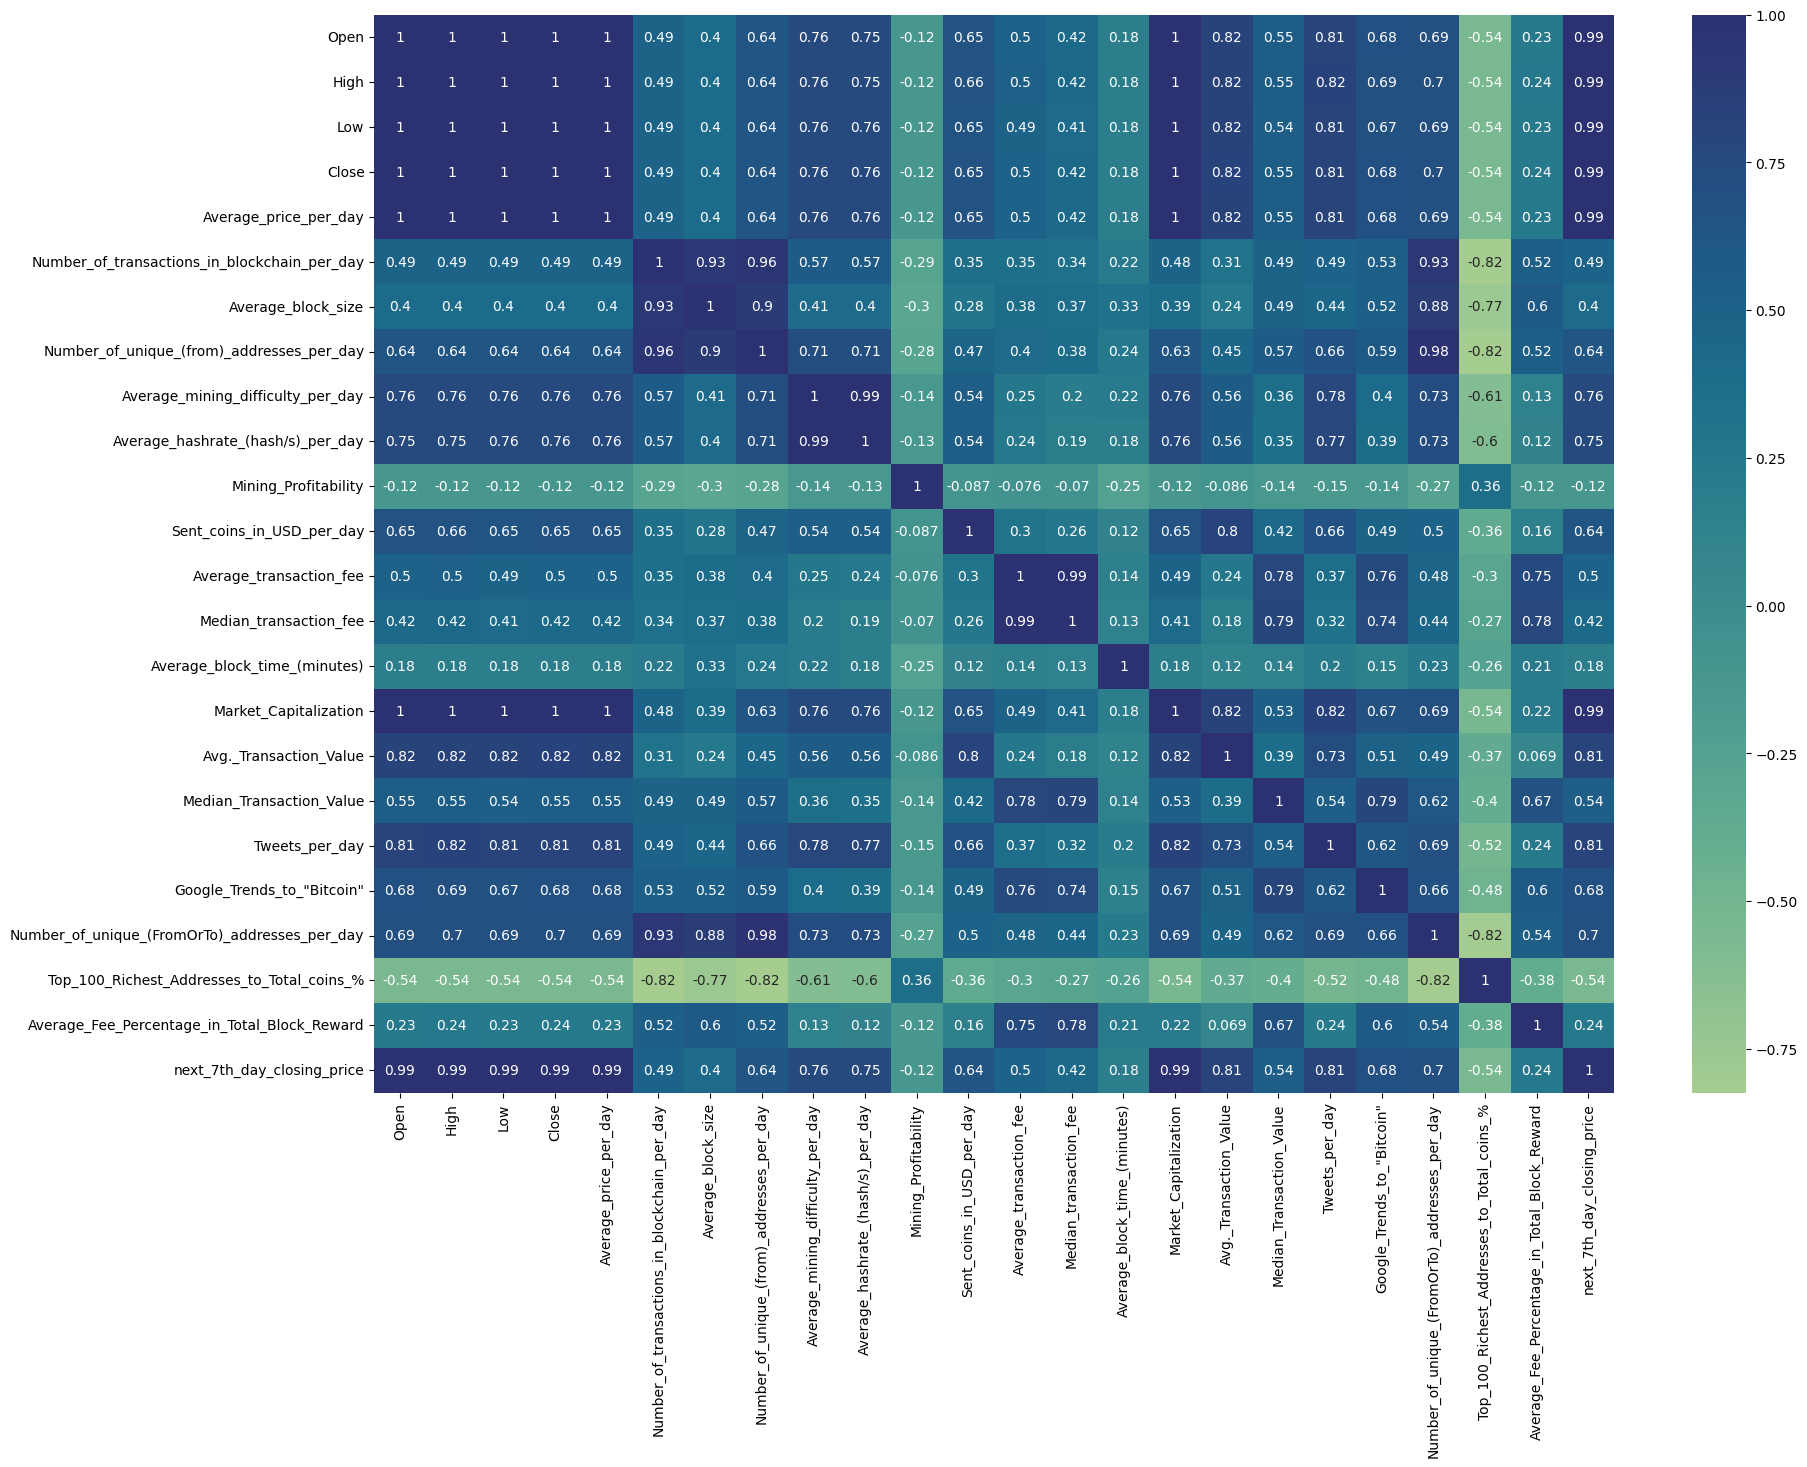

In [25]:
fig, ax = plt.subplots(figsize=(20, 14))
sb.heatmap(final_df.corr(), cmap='crest', ax=ax, annot=True)

### Exploratory Data Analysis

In [26]:
def plot_data(df,feature_name,exclude_feature2='next_7th_day_closing_price'):
    random_color = (random.random(), random.random(), random.random())
    df.plot(x='Date',y=feature_name,figsize=(25,5),grid=True,color=random_color)
    plt.title(f'Date VS {feature_name.replace("_"," ")}')
    plt.ylabel(feature_name)
    plt.show()

    df.plot(kind='kde',y=feature_name,figsize=(25,5),grid=True,color=random_color)
    plt.title(f'KDE-{feature_name.replace("_"," ")}')
    plt.xlabel('price')
    plt.show()

    corr = df.corr().loc[[feature_name],:].sort_values(by=feature_name,axis=1).drop(columns=[feature_name,exclude_feature2])
    plt.figure(figsize = (25,5))
    sb.heatmap(corr,cmap='tab10',square=True,annot=True,cbar=False,annot_kws={"fontsize":16},linewidths=1, linecolor='black',)
    plt.title(f'Correlation with other features')
    plt.show()

#### 7th Day Closing Price

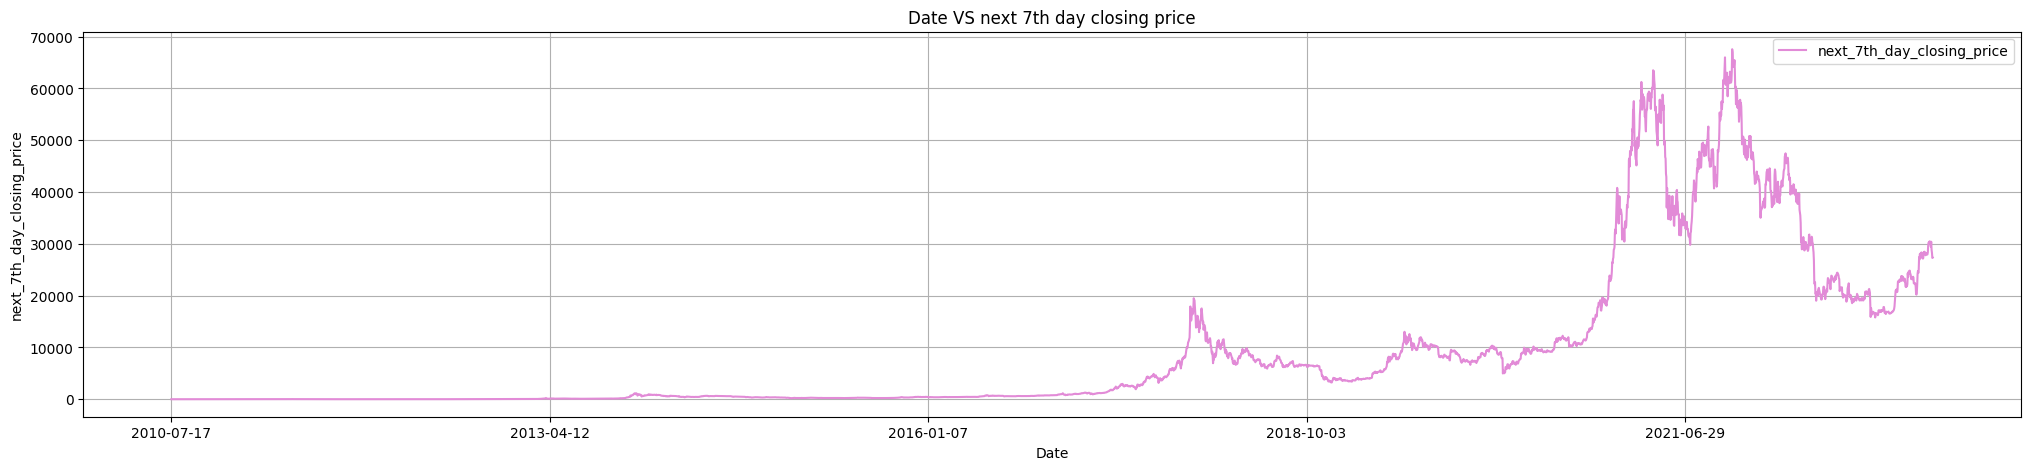

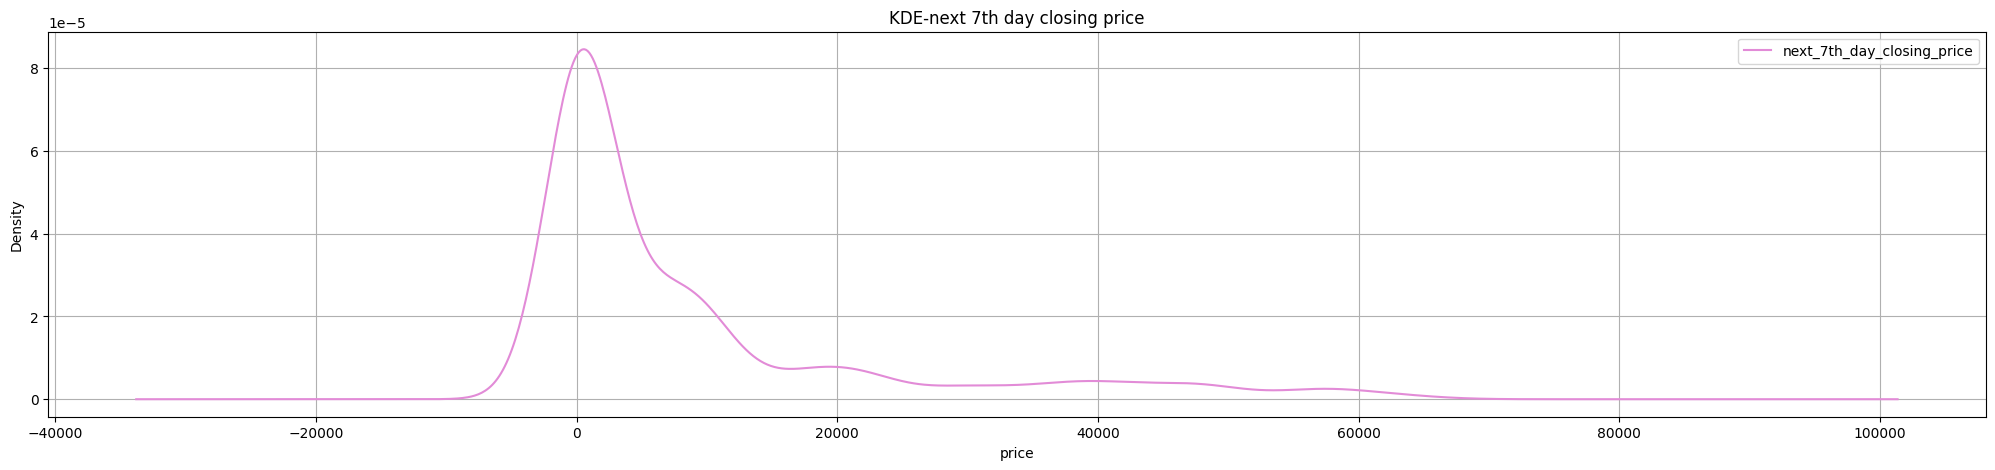

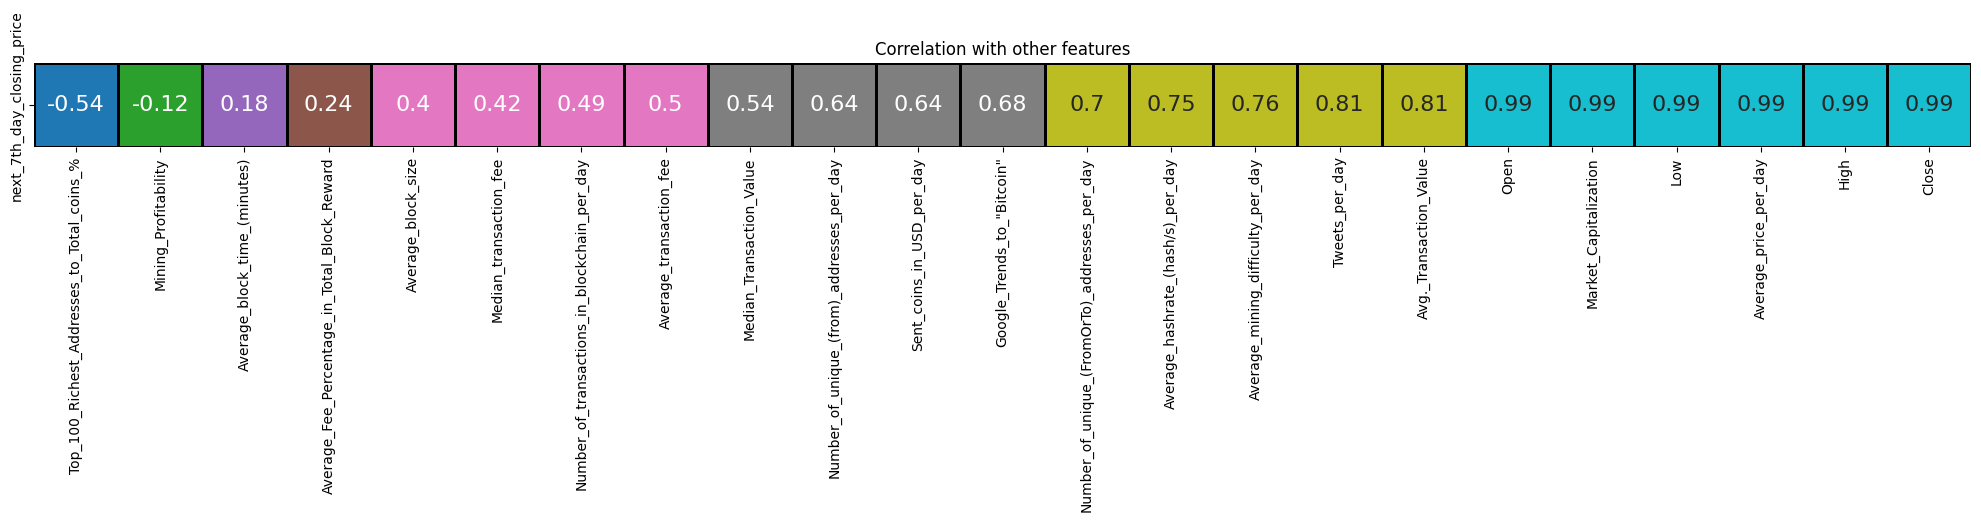

In [27]:
plot_data(final_df,feature_name='next_7th_day_closing_price')

### Tweets & Google Trends

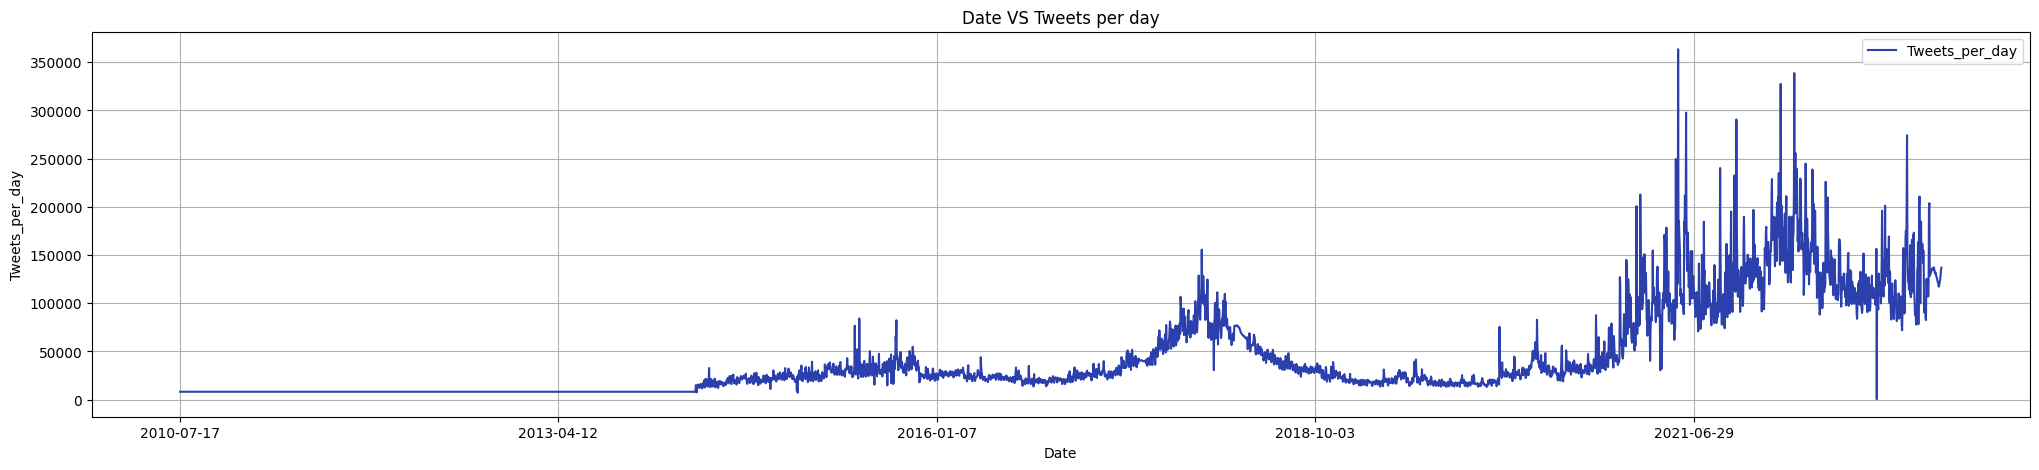

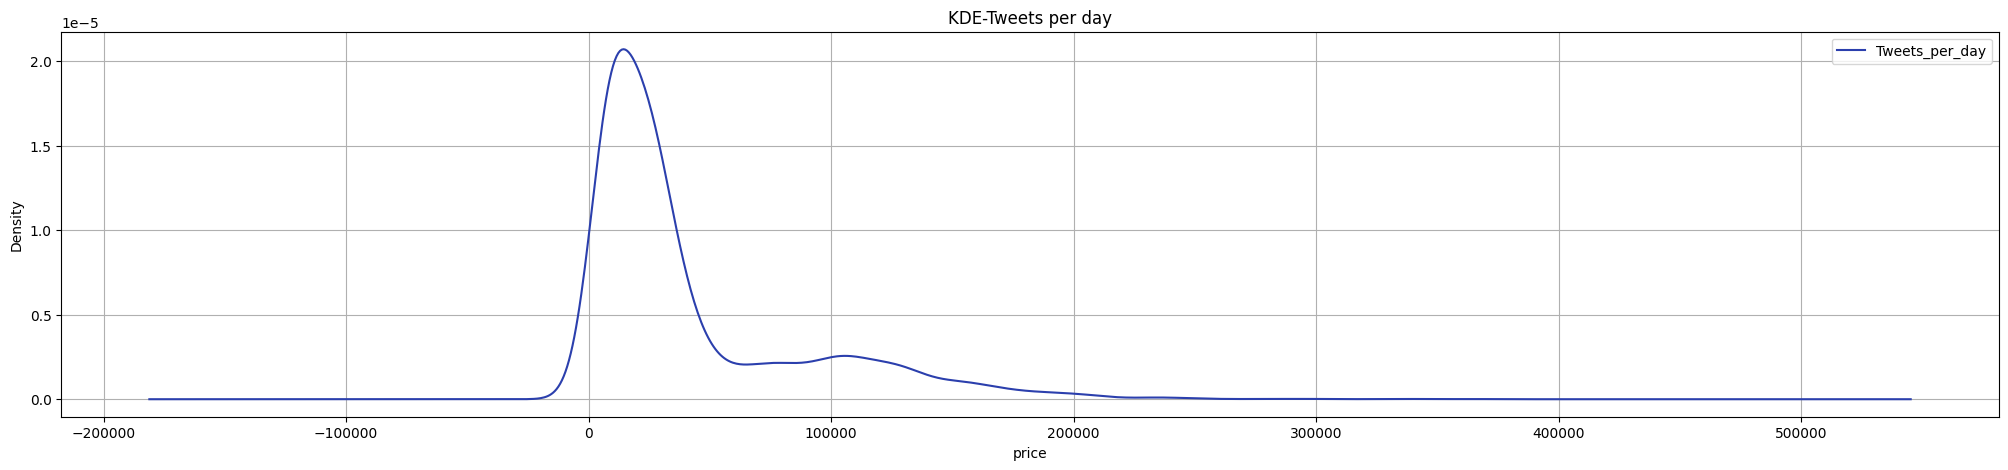

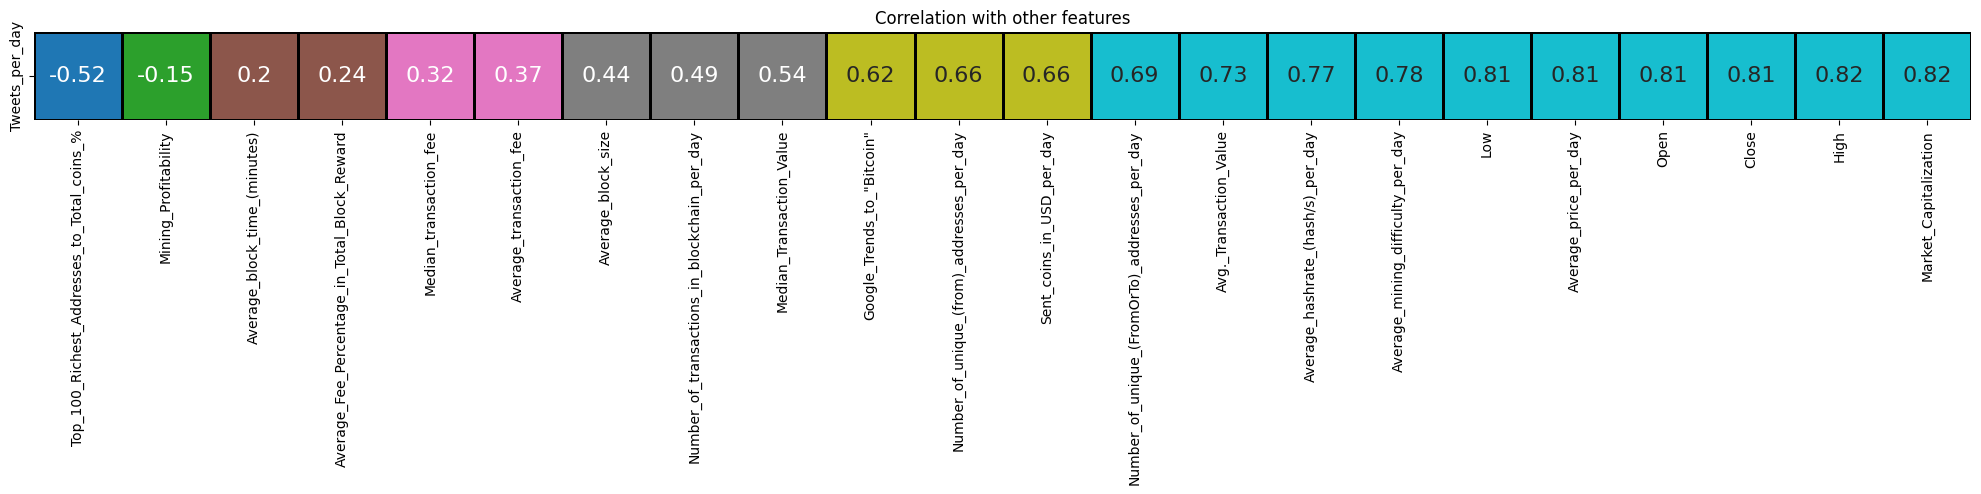

In [28]:
plot_data(final_df,feature_name='Tweets_per_day')

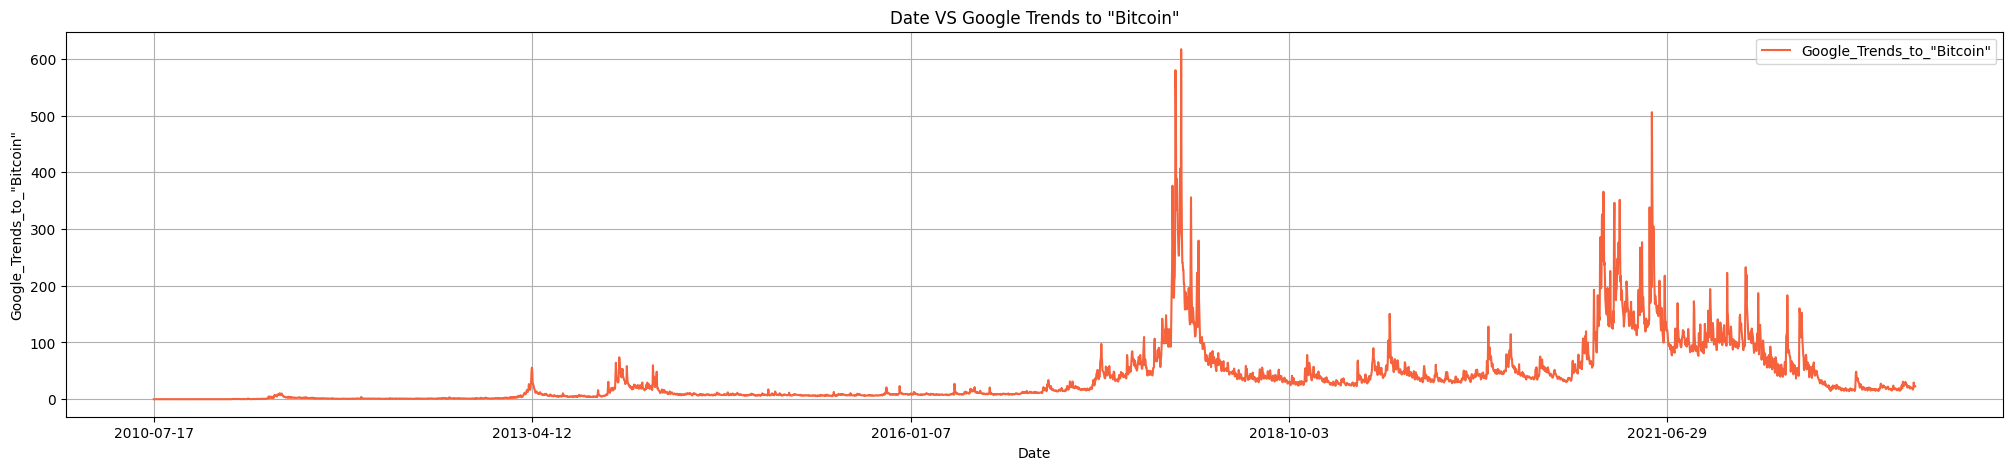

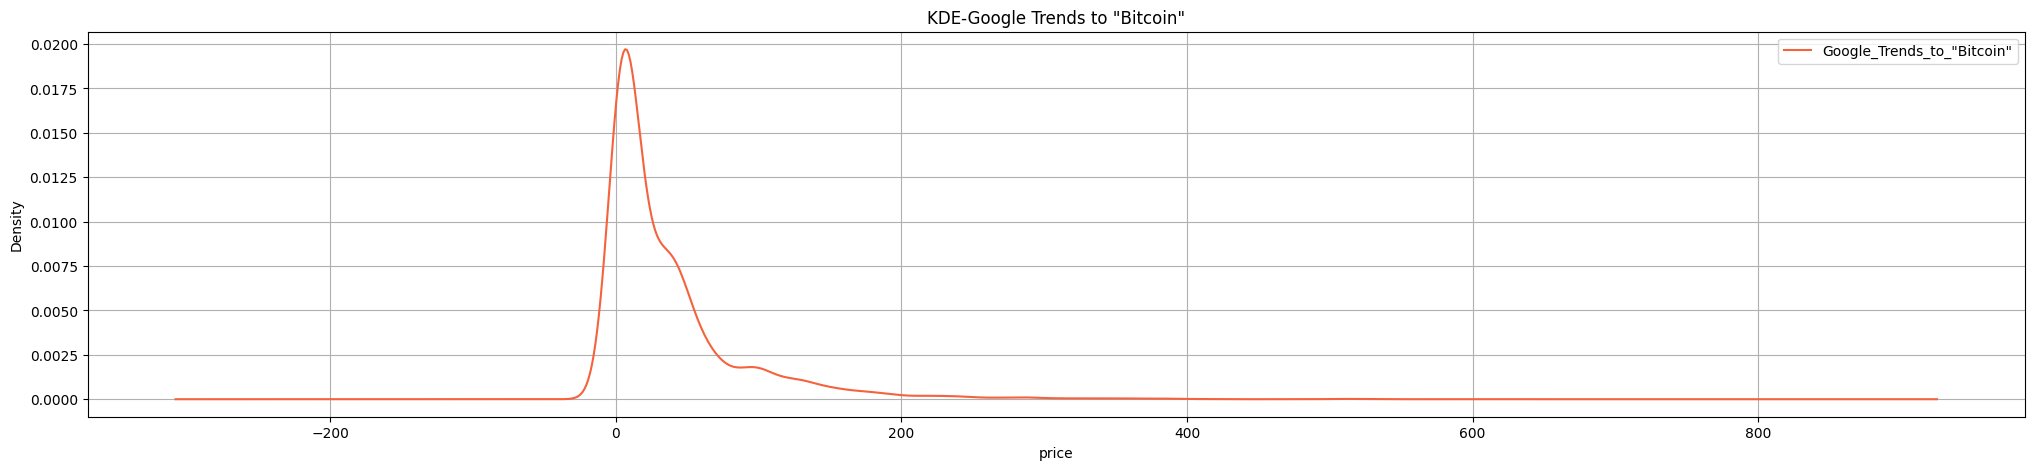

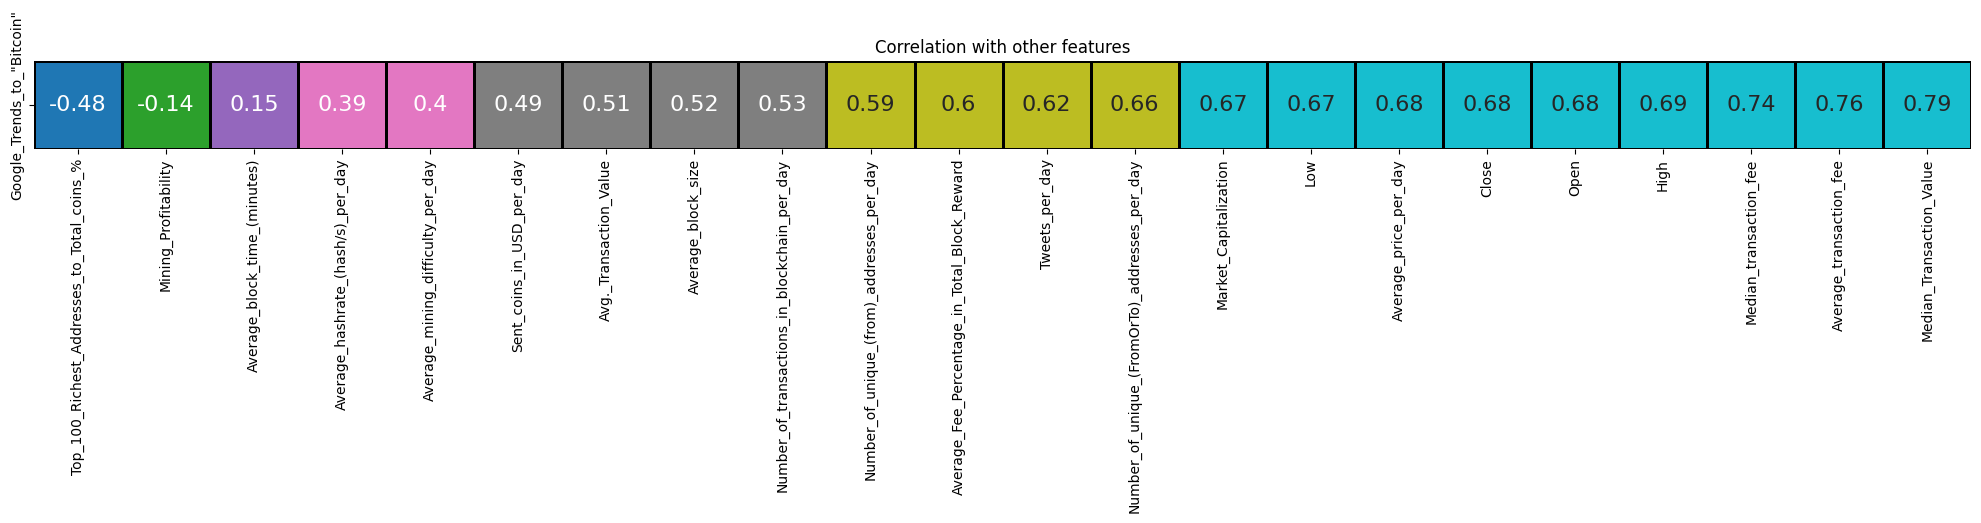

In [29]:
plot_data(final_df,feature_name='Google_Trends_to_"Bitcoin"')

#### The two social media trends appear to have predictive value as they exhibit a strong correlation with each other and a positive correlation with price.

***


### Feature Engineering


#### Adding technical indicators for each original feature as a new feature to the dataframe
#### Calculating technical indicators for 7,15,45 days
#### Technical indicators are mathematical calculations based on price, volume, or open interest of a security or a market. They are used by traders and analysts to gain insight into market trends and behavior.

In [30]:
def feature_smoothening(df,feature_name,smoothening_type,smoothening_range=[7,30,60],show_plot=False,show_original_Feature_in_plot=True):
    if smoothening_type == 'sma':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.sma(df[feature_name],j)

    elif smoothening_type == 'var':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.variance(df[feature_name],j)

    elif smoothening_type == 'stdev':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.stdev(df[feature_name],j)
    
    elif smoothening_type == 'ema':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.ema(df[feature_name],j)

    elif smoothening_type == 'wma':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.wma(df[feature_name],j)

    elif smoothening_type == 'rsi':
        for j in smoothening_range:
             df[f'{smoothening_type}{j} {feature_name}'] = ta.rsi(df[feature_name],j)

    elif smoothening_type == 'roc':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.roc(df[feature_name],j)  

    elif smoothening_type == 'dema':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.dema(df[feature_name],j) 

    elif smoothening_type == 'tema':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.tema(df[feature_name],j) 

    elif smoothening_type == 'bband_lower':
        for j in smoothening_range:
            bband_df = ta.bbands(df[feature_name],j)
            df[f'{smoothening_type}{j} {feature_name}'] = bband_df[f'BBL_{j}_2.0']

    elif smoothening_type == 'bband_upper':
        for j in smoothening_range:
            bband_df = ta.bbands(df[feature_name],j)
            df[f'{smoothening_type}{j} {feature_name}'] = bband_df[f'BBU_{j}_2.0']

    elif smoothening_type == 'macd':
        macd_df = ta.macd(df[feature_name])
        df[f'{smoothening_type} hist {feature_name}'] = macd_df['MACDh_12_26_9']
        df[f'{smoothening_type} signal {feature_name}'] = macd_df['MACDs_12_26_9']
        df[f'{smoothening_type} {feature_name}'] = macd_df['MACD_12_26_9']

    
    if show_plot == True and show_original_Feature_in_plot==True :
        df[[feature_name]+[i for i in list(df.columns) if i.split(" ")[-1] == feature_name and i.split(" ")[0][0:len(smoothening_type)] == smoothening_type]].plot(kind='line',figsize=(25,5))
        plt.grid()
        plt.title(f'Feature Smoothening-{feature_name} by {smoothening_type}')
        plt.xticks([])
        plt.show()

    elif show_plot == True and show_original_Feature_in_plot==False :
        df[[i for i in list(df.columns) if i.split(" ")[-1] == feature_name and i.split(" ")[0][0:len(smoothening_type)] == smoothening_type]].plot(kind='line',figsize=(25,5))
        plt.grid()
        plt.title(f'Feature Smoothening-{feature_name} by {smoothening_type}')
        plt.xticks([])
        plt.show()

In [31]:
feature_list = [i for i in list(final_df.columns) if i not in ['Date','next_7th_day_closing_price']]
feature_list

['Open',
 'High',
 'Low',
 'Close',
 'Average_price_per_day',
 'Number_of_transactions_in_blockchain_per_day',
 'Average_block_size',
 'Number_of_unique_(from)_addresses_per_day',
 'Average_mining_difficulty_per_day',
 'Average_hashrate_(hash/s)_per_day',
 'Mining_Profitability',
 'Sent_coins_in_USD_per_day',
 'Average_transaction_fee',
 'Median_transaction_fee',
 'Average_block_time_(minutes)',
 'Market_Capitalization',
 'Avg._Transaction_Value',
 'Median_Transaction_Value',
 'Tweets_per_day',
 'Google_Trends_to_"Bitcoin"',
 'Number_of_unique_(FromOrTo)_addresses_per_day',
 'Top_100_Richest_Addresses_to_Total_coins_%',
 'Average_Fee_Percentage_in_Total_Block_Reward']

### Calculating SMA
#### Simple Moving Average. It is a widely used technical indicator that is used to identify the direction of a trend and smooth out price fluctuations by calculating the mean of a set of prices over a specified period of time

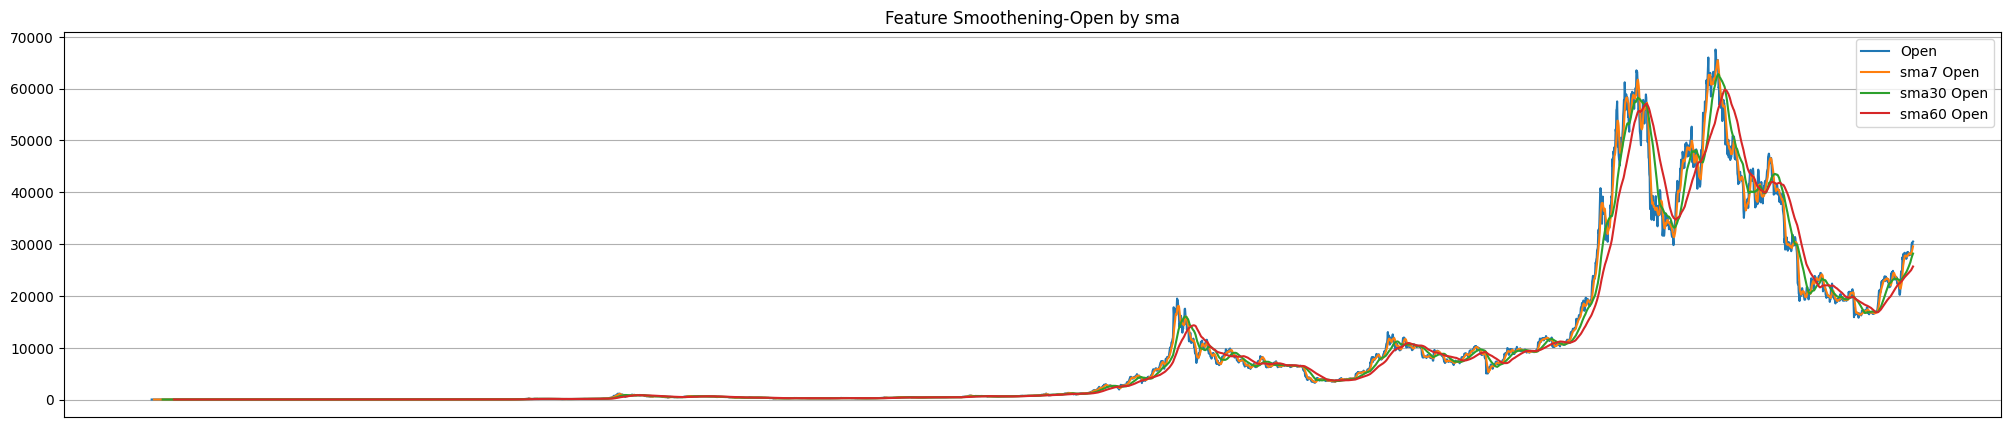

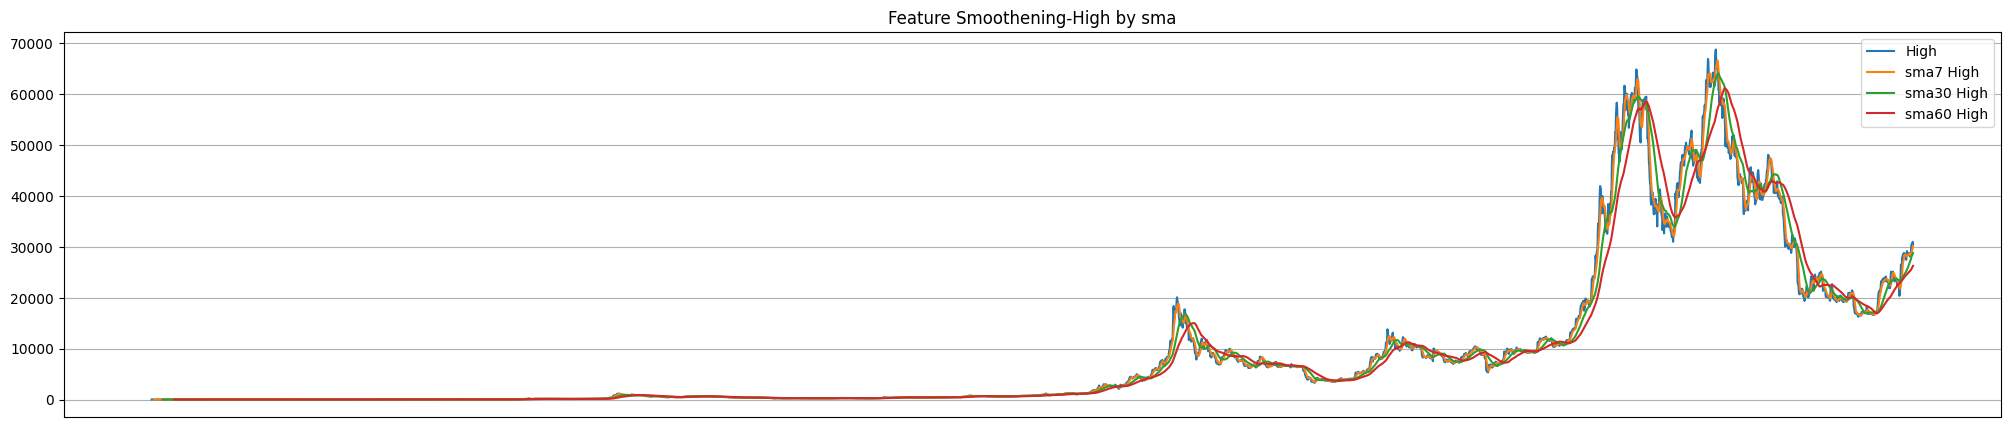

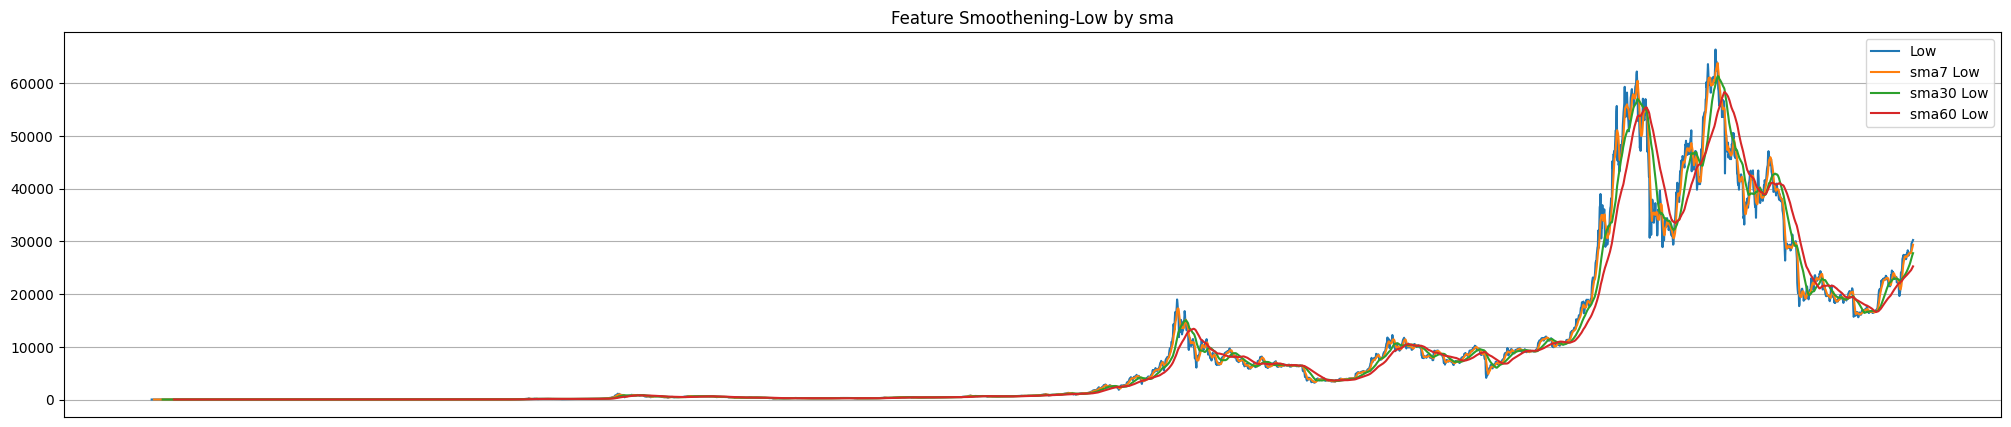

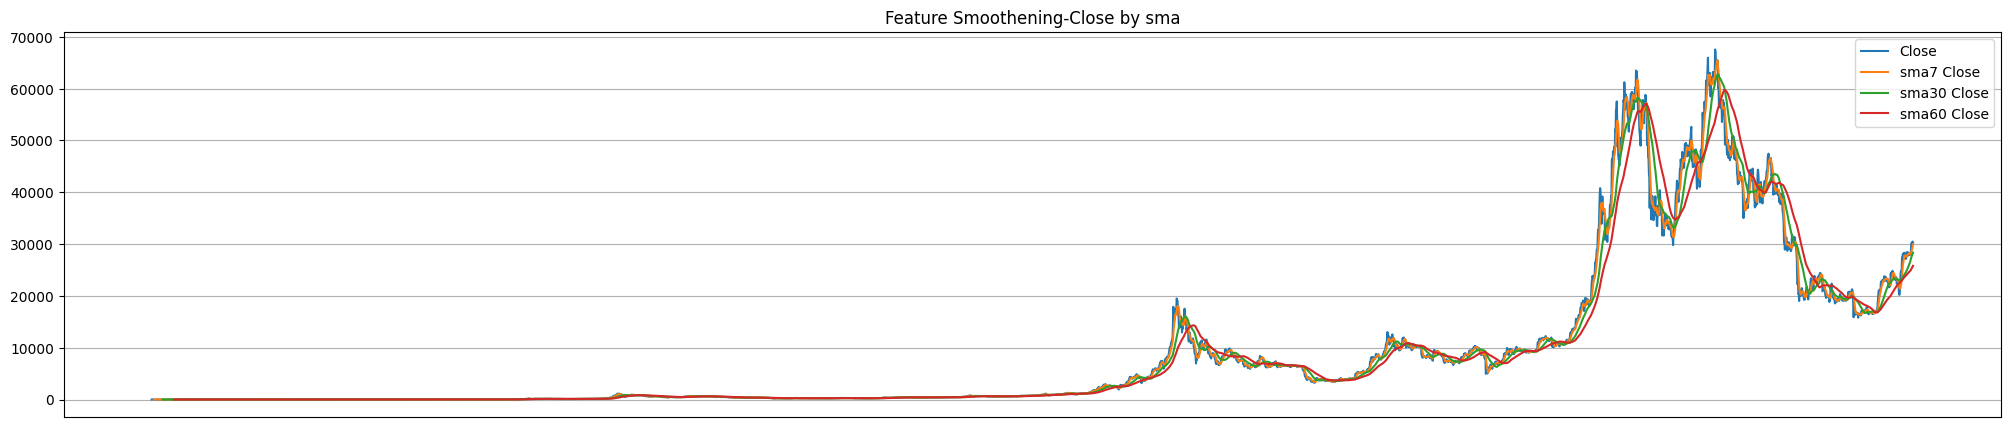

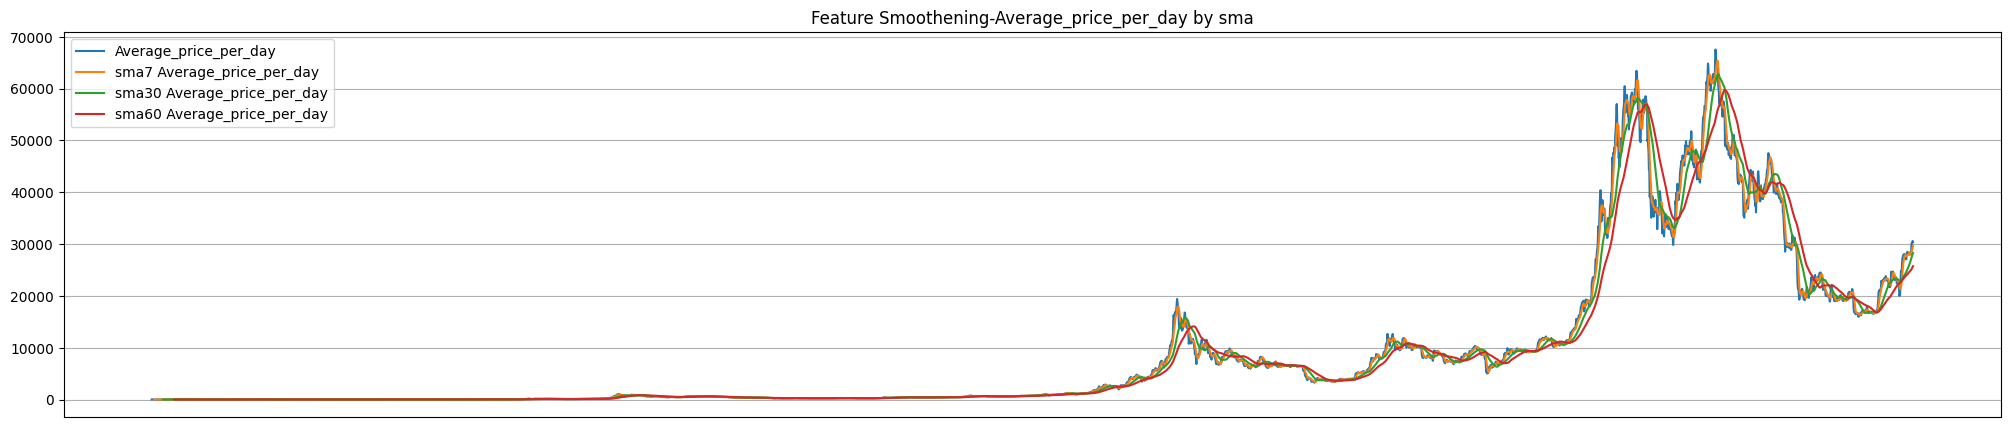

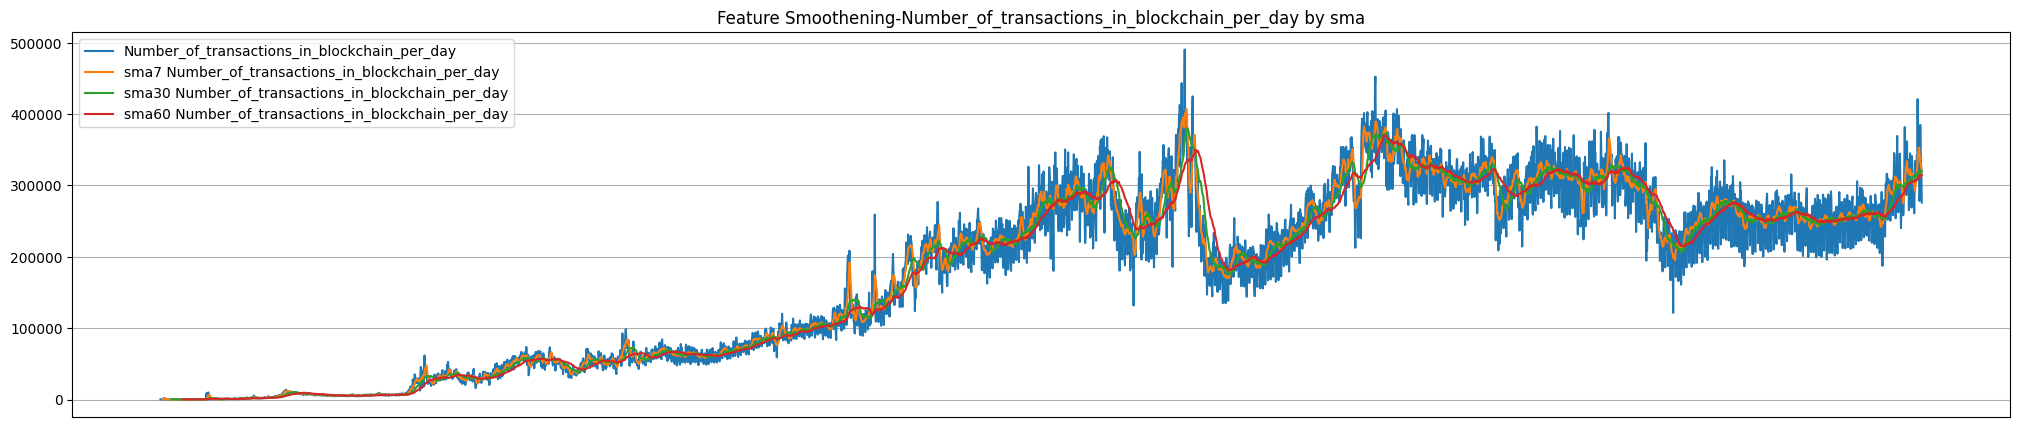

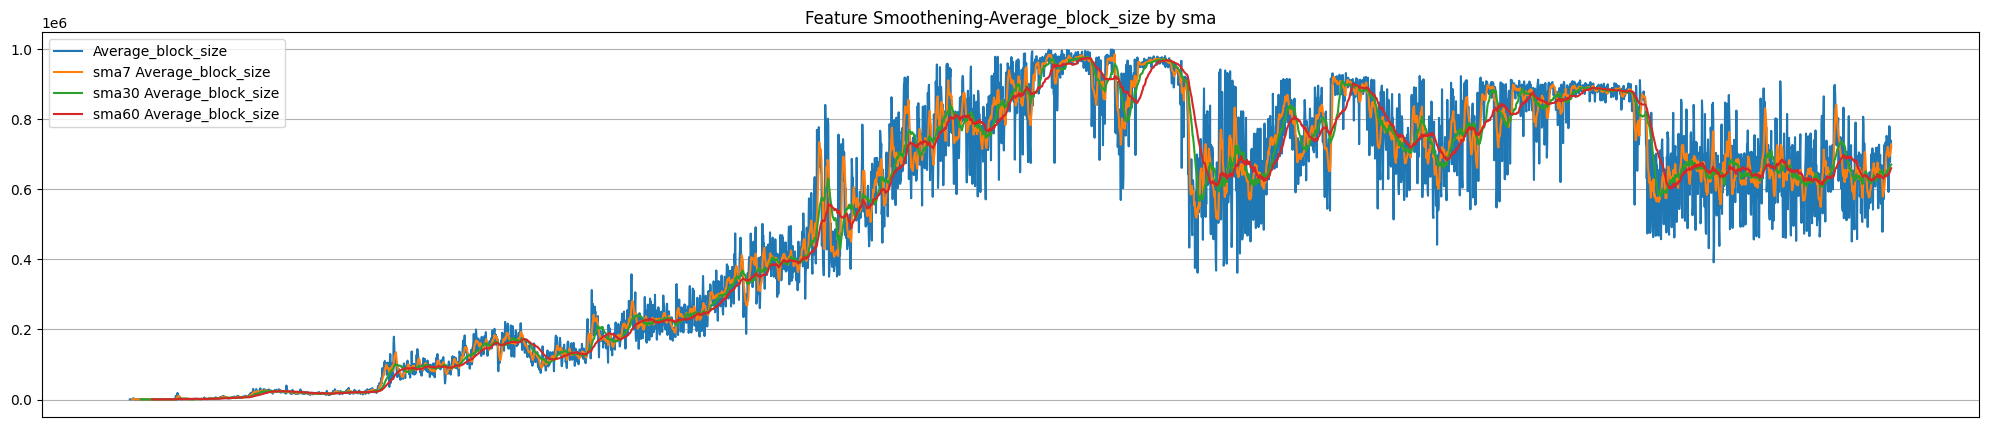

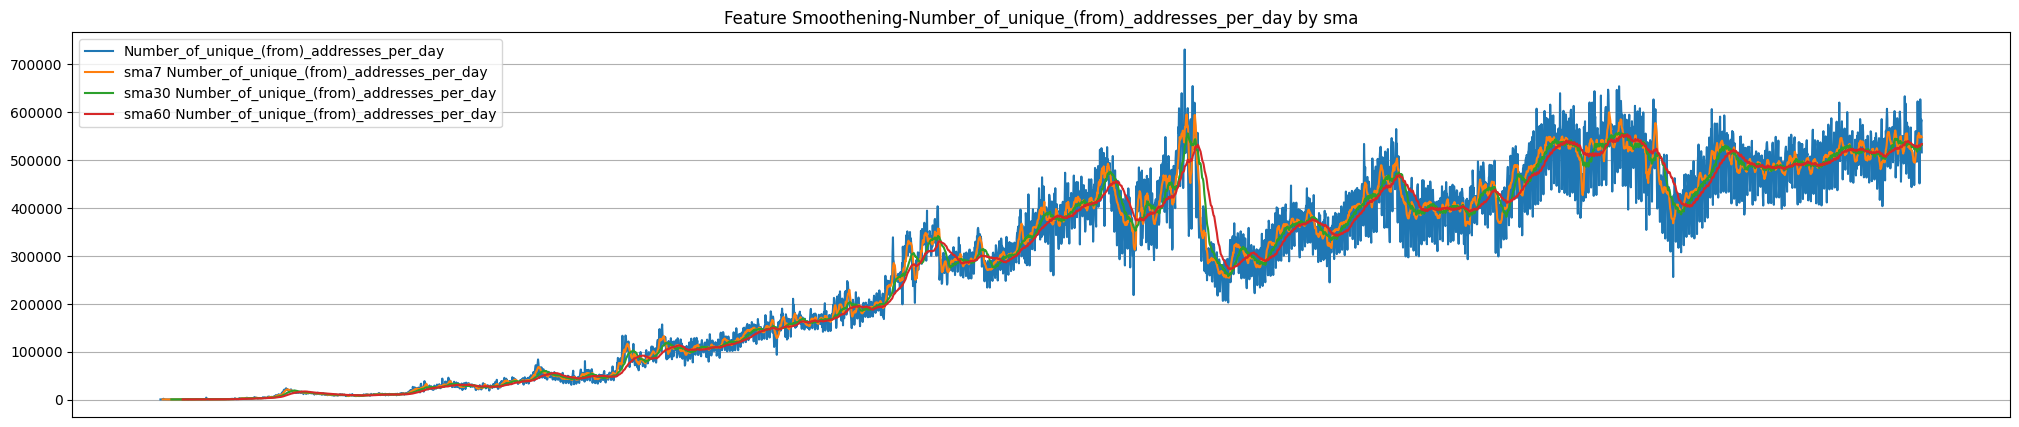

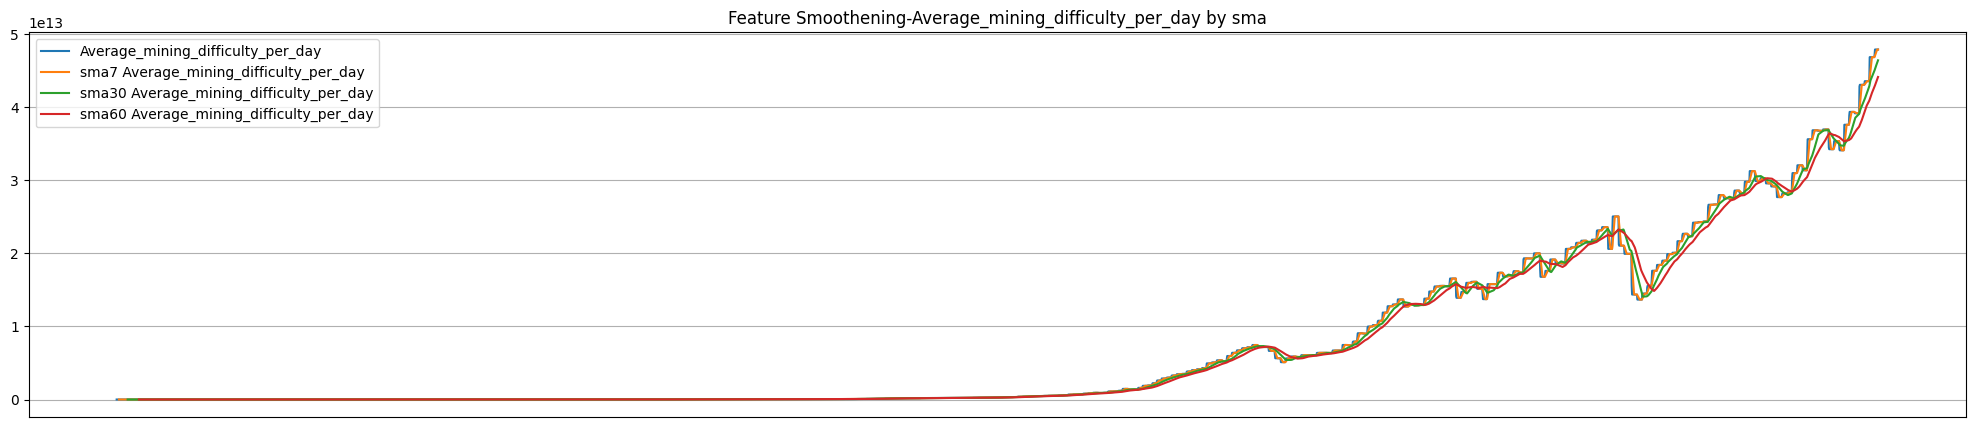

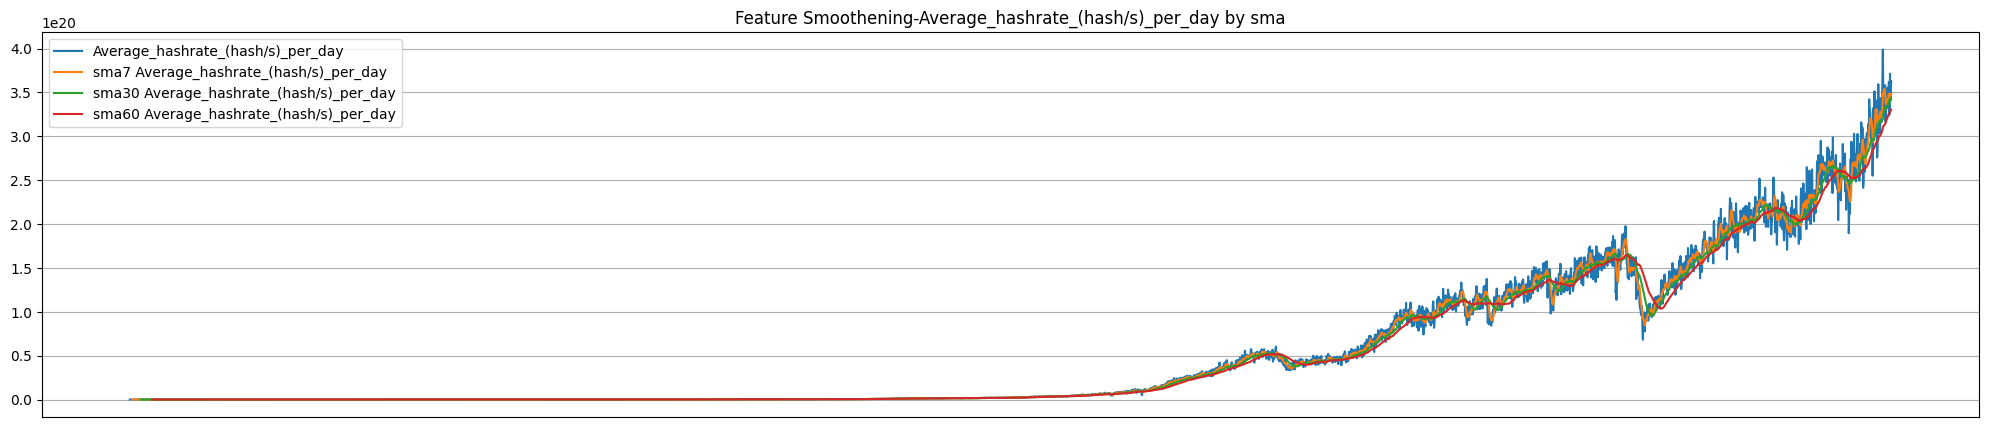

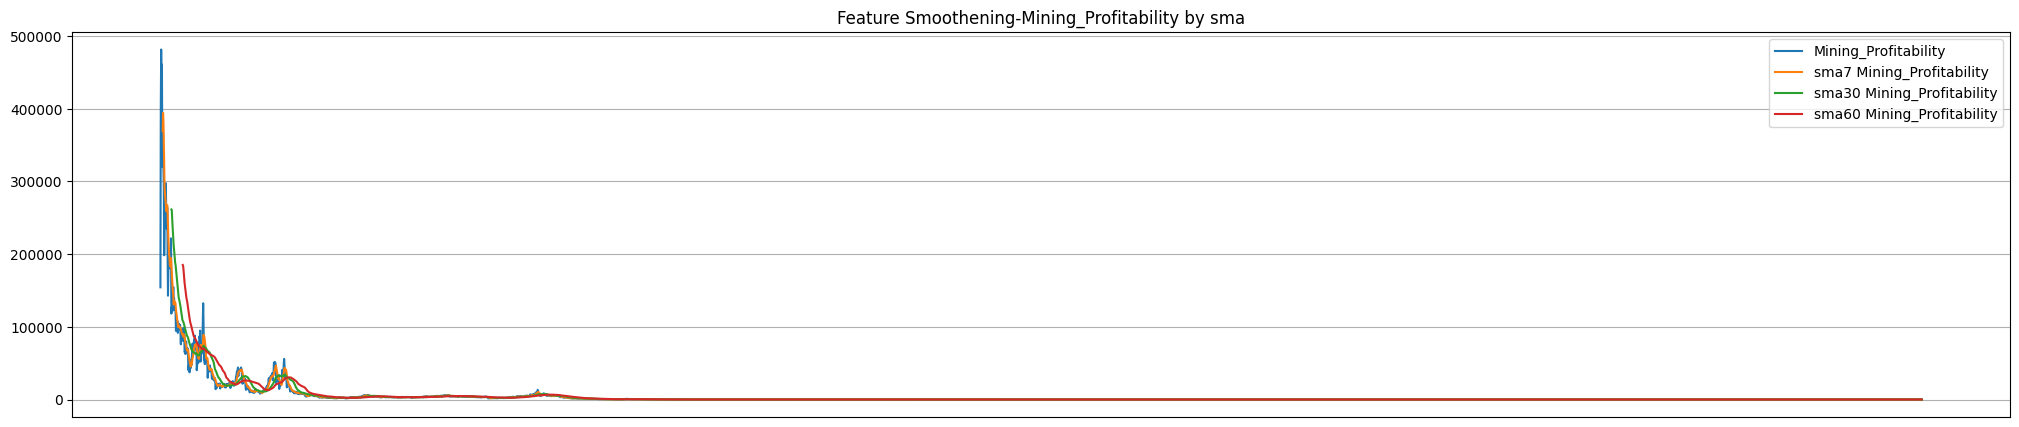

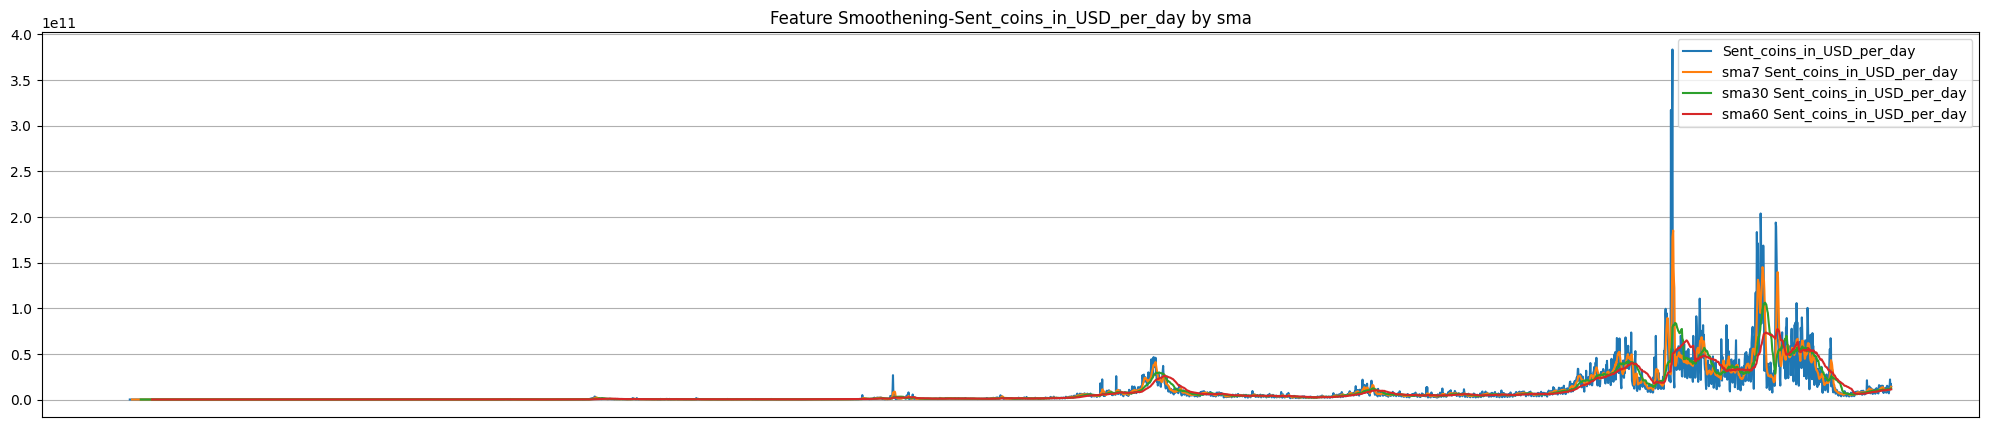

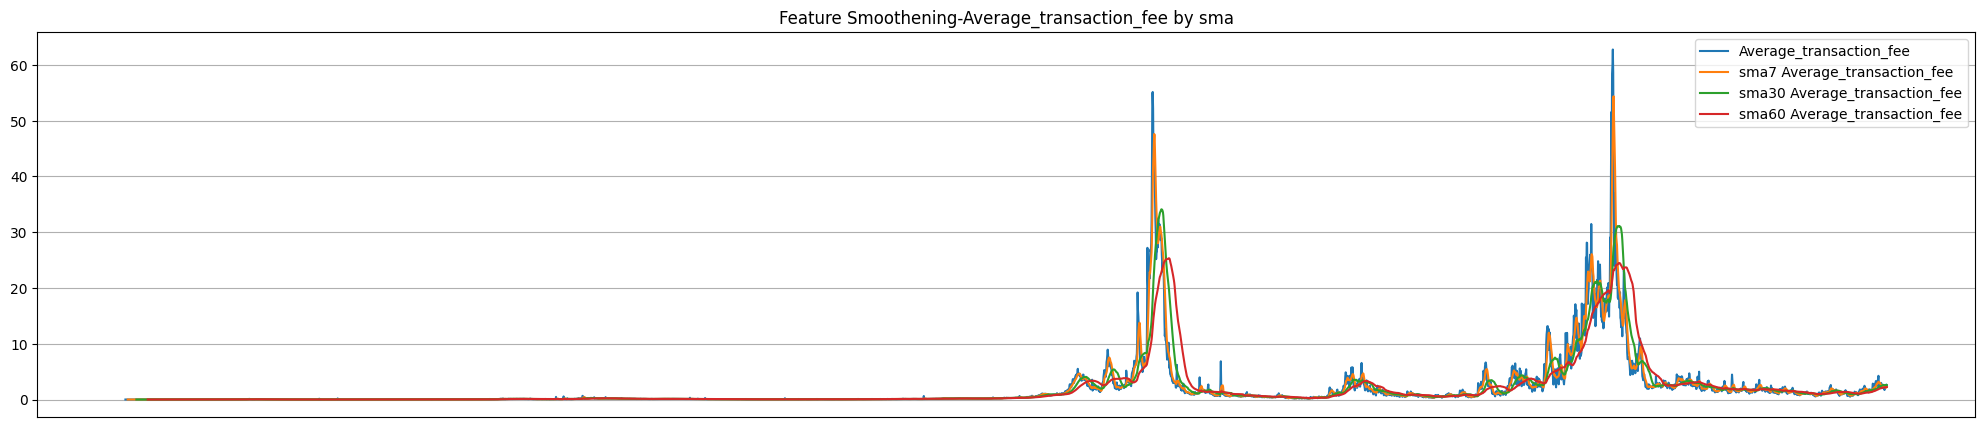

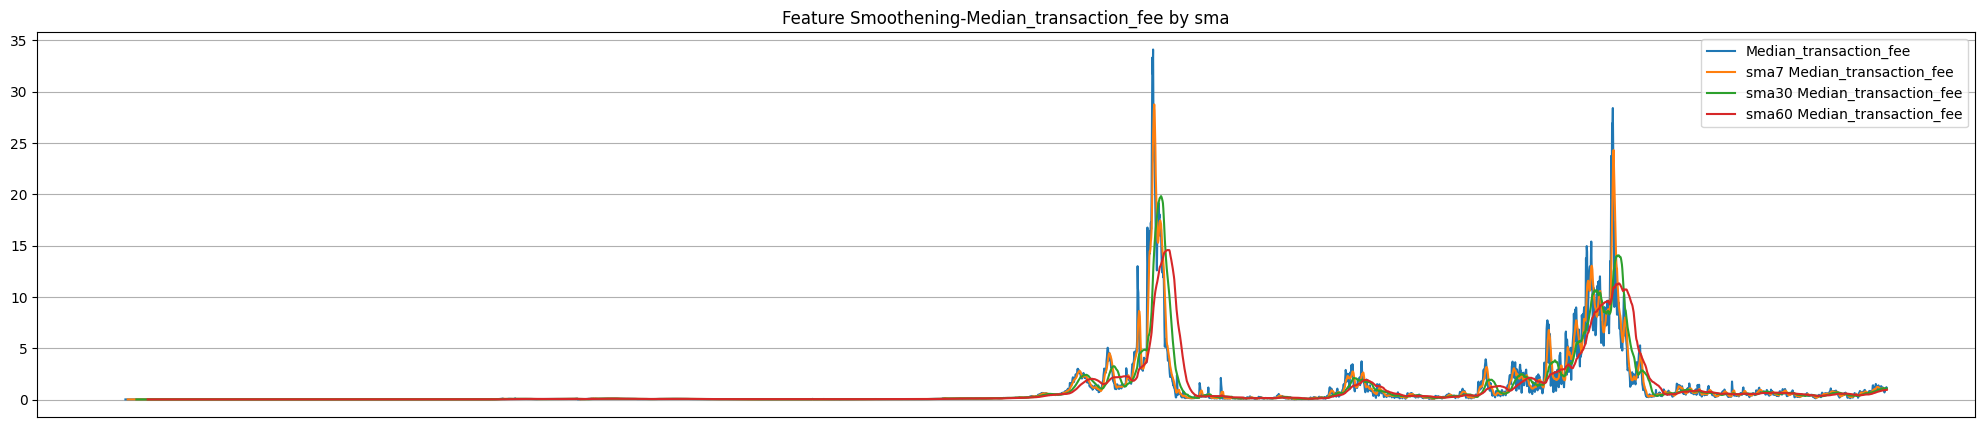

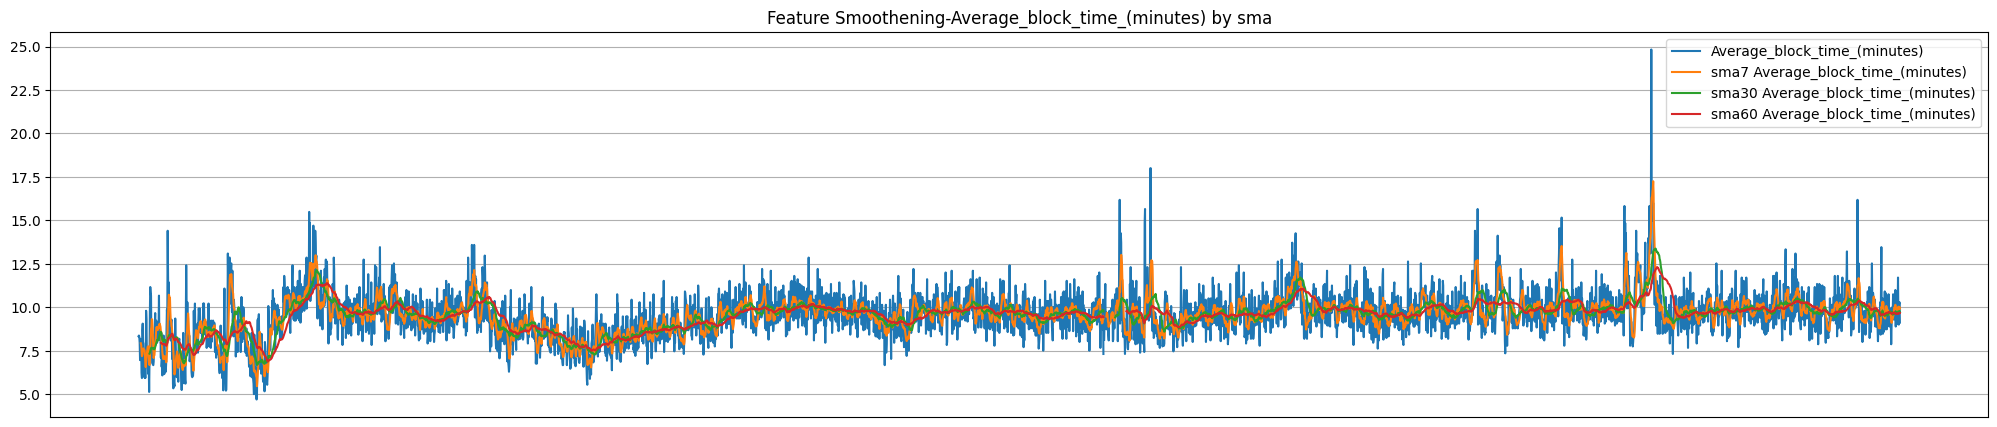

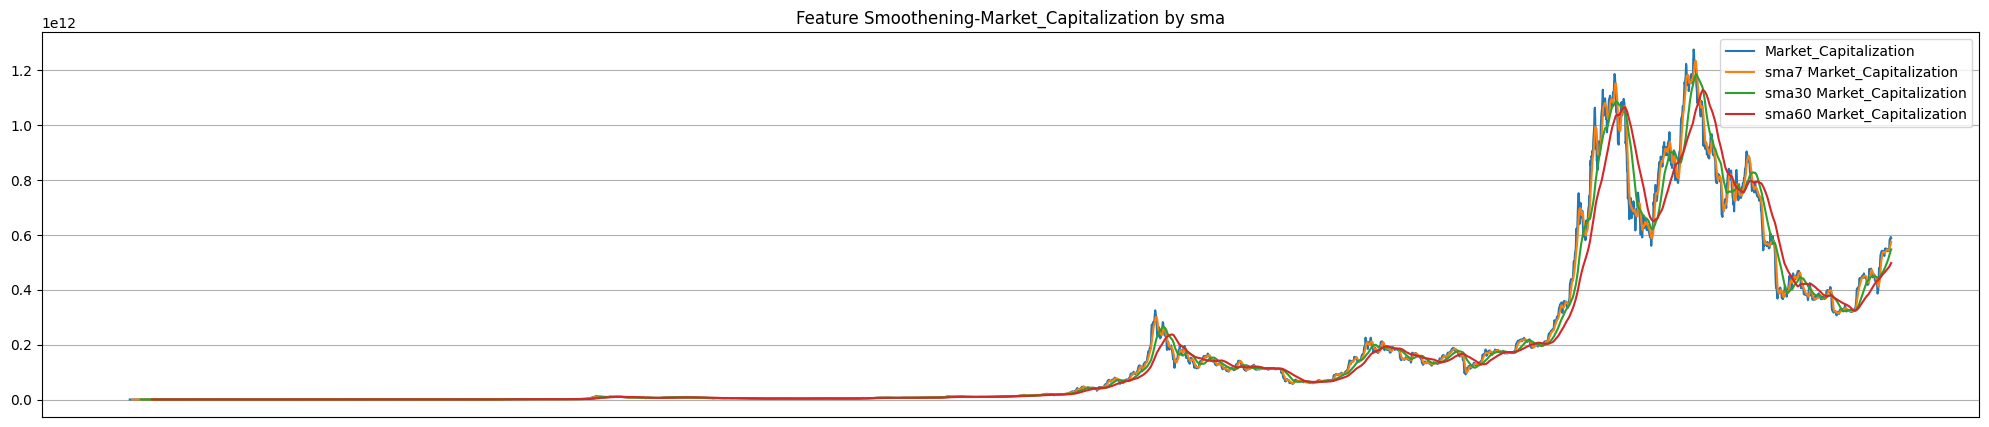

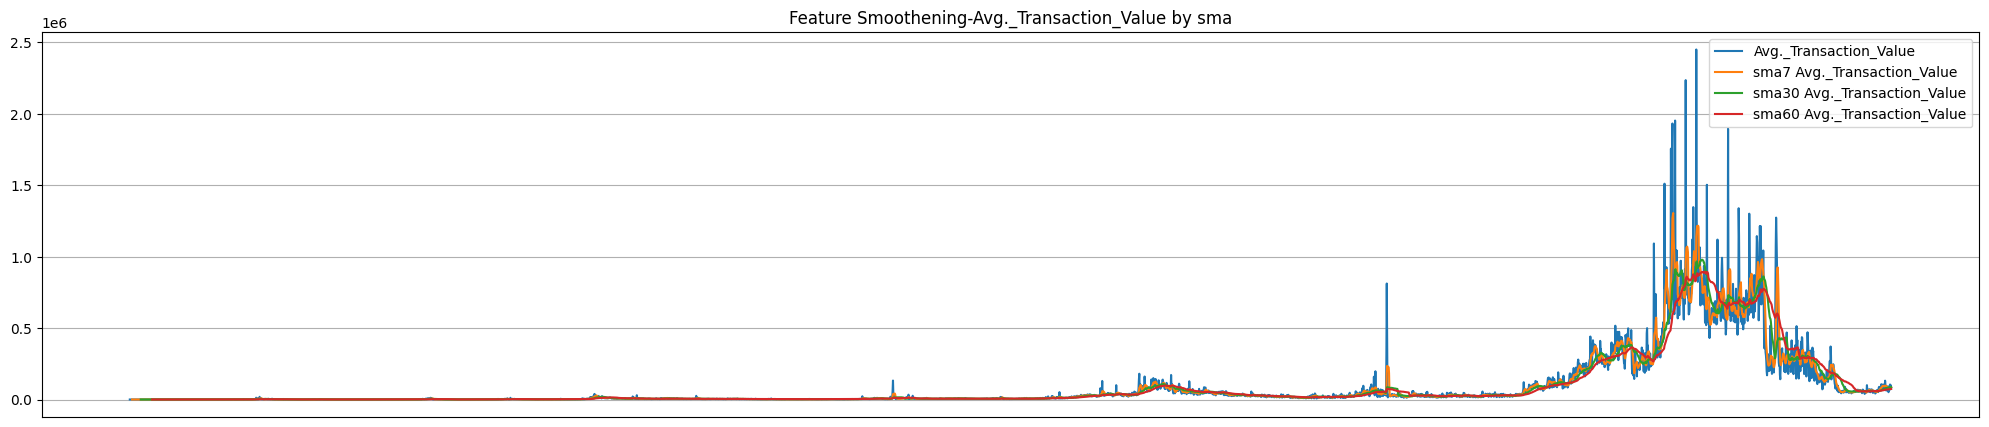

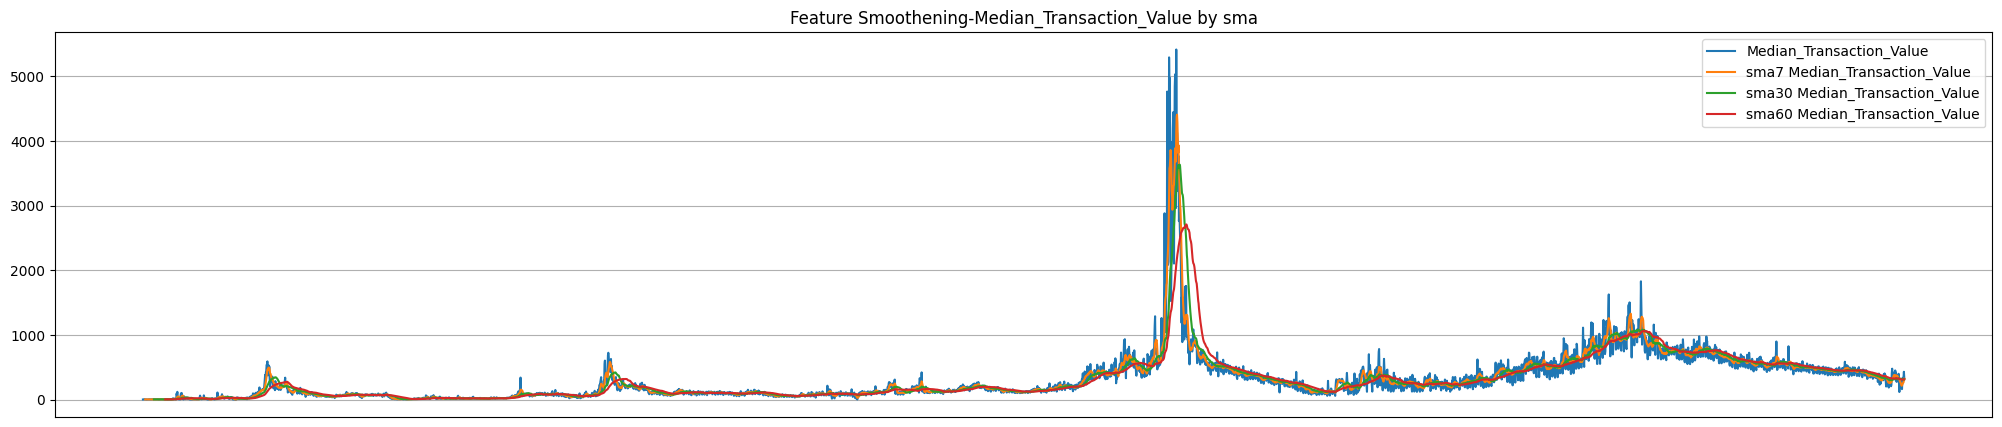

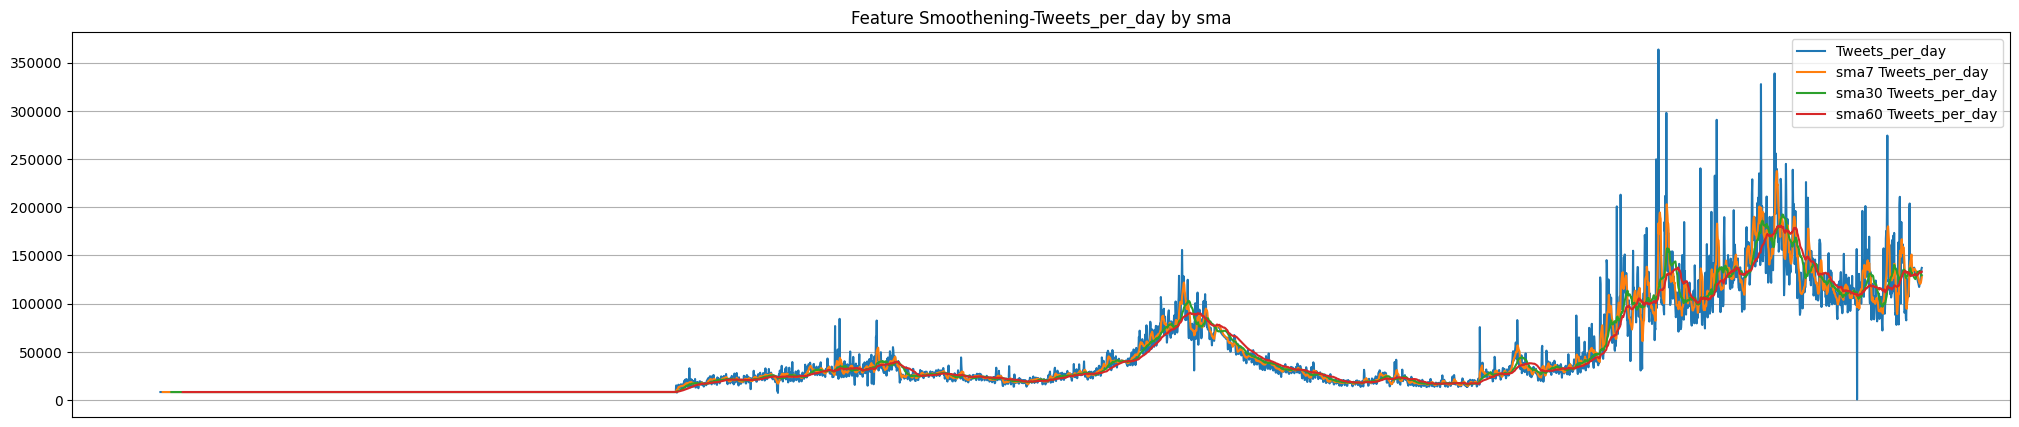

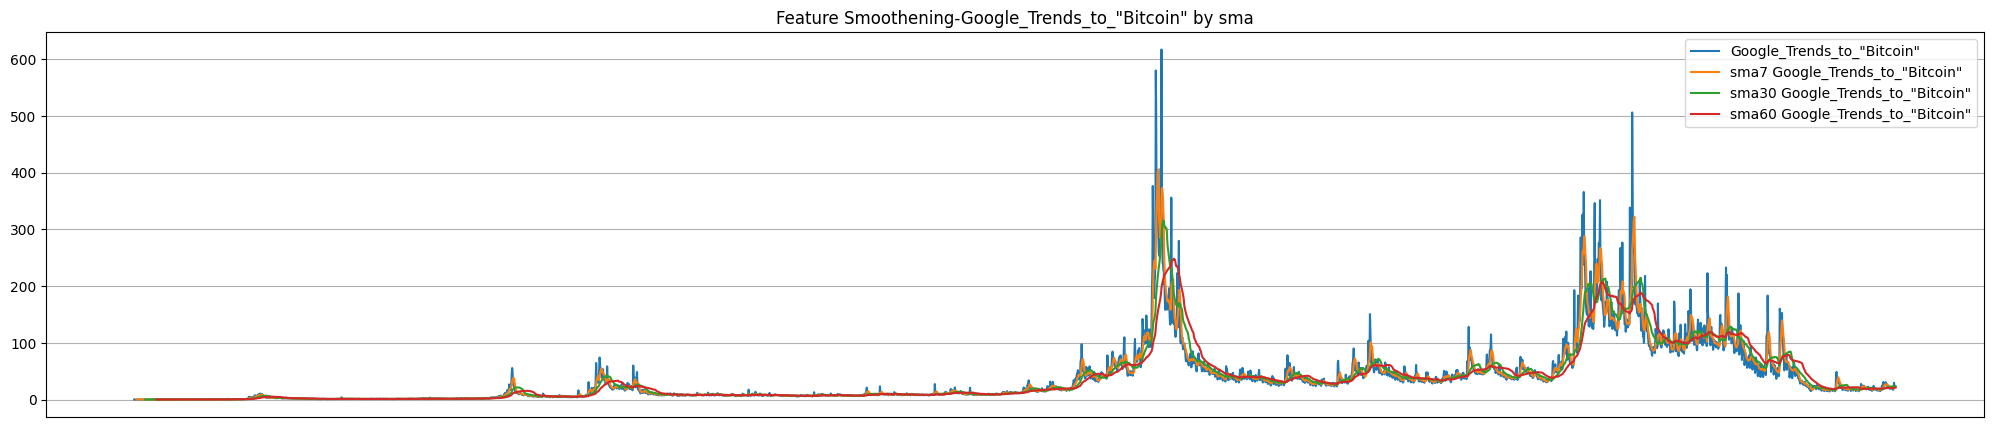

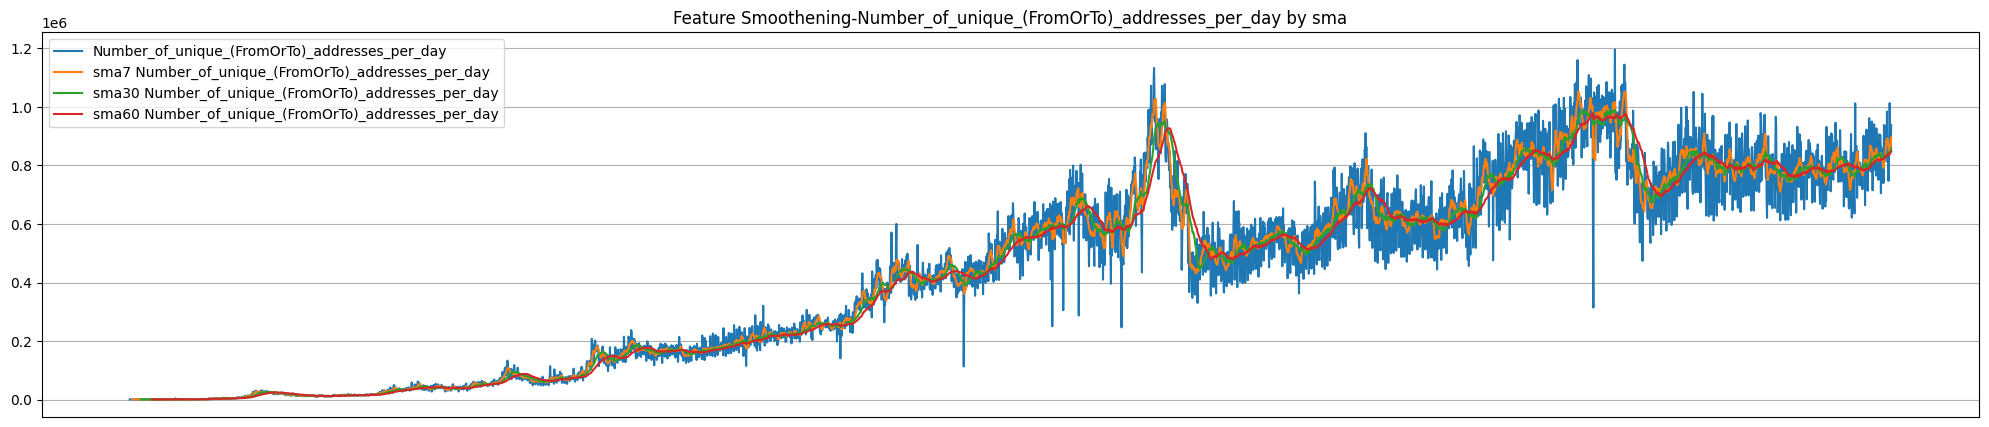

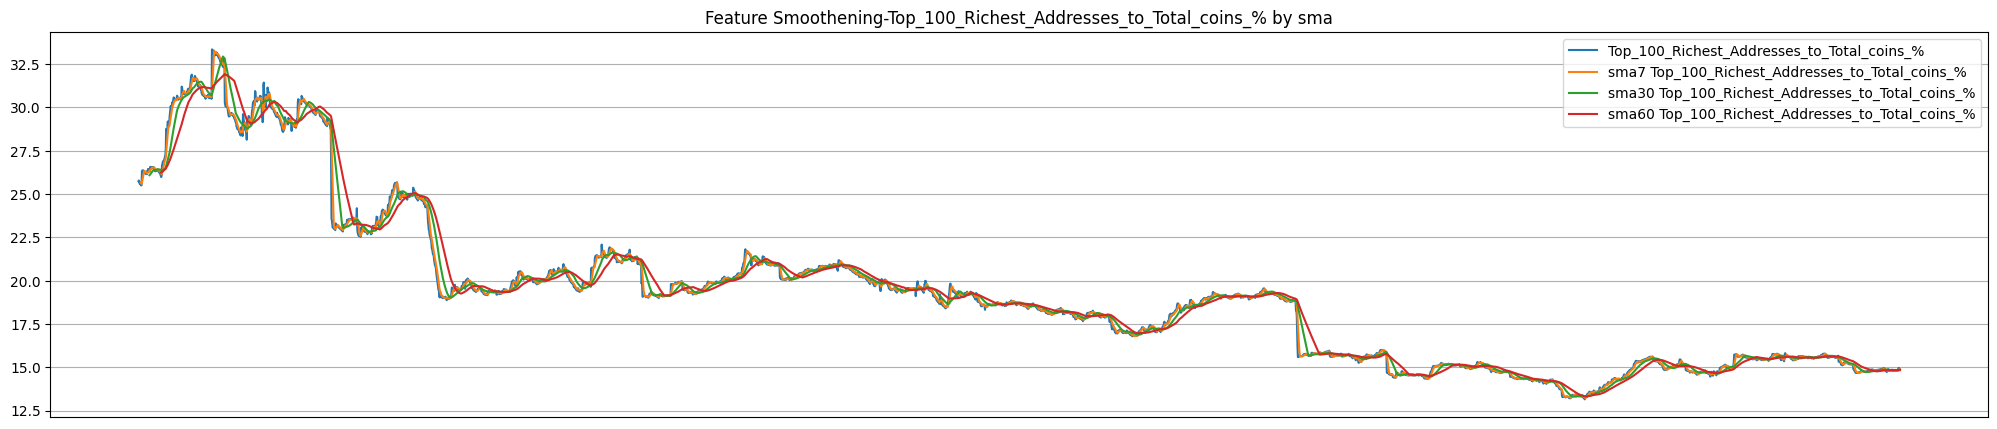

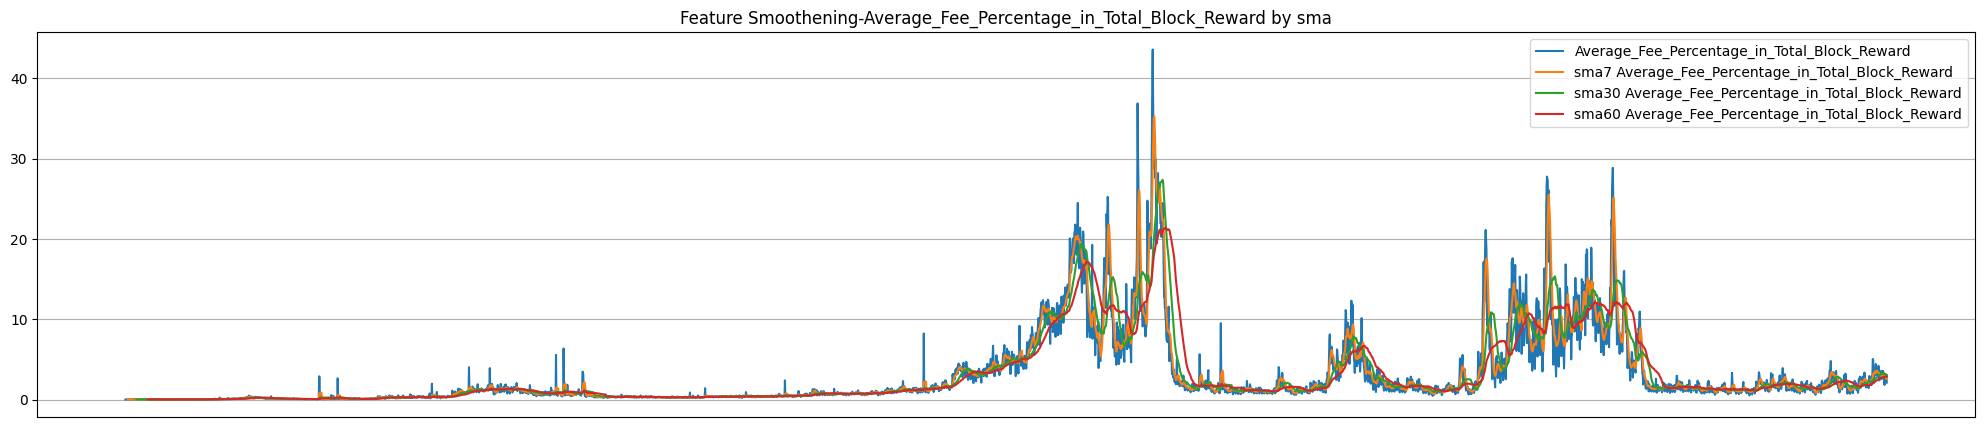

In [32]:
for feature in feature_list:
    feature_smoothening(final_df,feature,'sma',show_plot=True)

### Calculating other indicators and adding to the dataframe

In [33]:
for feature in feature_list:
    feature_smoothening(final_df,feature,'stdev',show_plot=False,show_original_Feature_in_plot=False)
    feature_smoothening(final_df,feature,'var',show_plot=False,show_original_Feature_in_plot=False)
    feature_smoothening(final_df,feature,'rsi',show_plot=False,show_original_Feature_in_plot=False)
    feature_smoothening(final_df,feature,'ema',show_plot=False,show_original_Feature_in_plot=False)
    feature_smoothening(final_df,feature,'wma',show_plot=False,show_original_Feature_in_plot=False)
    feature_smoothening(final_df,feature,'roc',show_plot=False,show_original_Feature_in_plot=False)
    feature_smoothening(final_df,feature,'dema',show_plot=False,show_original_Feature_in_plot=False)
    feature_smoothening(final_df,feature,'tema',show_plot=False,show_original_Feature_in_plot=False)
    feature_smoothening(final_df,feature,'bband_lower',show_plot=False,show_original_Feature_in_plot=False)
    feature_smoothening(final_df,feature,'bband_upper',show_plot=False,show_original_Feature_in_plot=False)
    feature_smoothening(final_df,feature,'macd',show_plot=False,show_original_Feature_in_plot=False)

### Add log returns features
#### Log return, also known as logarithmic return, is a method of measuring the rate of return on an investment over a specific period of time. It is calculated by taking the natural logarithm of the ratio of the ending price to the beginning price

In [34]:
def lag_column_creator(df, num_lags):
    for lag_num in range(1, num_lags + 1): 
        df[f'lags_{lag_num}'] = df['log_returns'].shift(lag_num) 
    return df

In [35]:
final_df['log_returns'] = np.log(final_df['Close'] / final_df['Close'].shift(1))
final_df = lag_column_creator(final_df, 7)

In [36]:
final_df = final_df.fillna(method='bfill')
final_df = final_df.fillna(method='ffill')

In [37]:
final_df.shape

(4656, 861)

### Data Scaling
#### RobustScaler is used to reduce the effect of outliers, and then MinMaxScaler is used to normalize the features between 0 and 1.

In [39]:
X = final_df.drop(['Date','next_7th_day_closing_price'],axis=1)
X_scaled = X.copy()

scaler = RobustScaler()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

scaler = MinMaxScaler()
X_scaled[X.columns] =  scaler.fit_transform(X_scaled[X.columns])

### Feature Selection

In [40]:
def feature_imp(df,feat_importance,n_select_features):
    feat_imp_df = pd.DataFrame(data = {"Feature Name": df.columns,"Feature Importance":feat_importance})

    feat_imp_df = feat_imp_df.sort_values("Feature Importance",ascending=False)[:n_select_features]

    fig,ax = plt.subplots(figsize=(14,12))
    ax = sb.barplot(x = "Feature Importance",y = "Feature Name",data=feat_imp_df,palette="nipy_spectral")
    plt.title('Feature Importances')

    cmap = plt.get_cmap('nipy_spectral_r',n_select_features)
    minfi = min(feat_imp_df['Feature Importance'])
    maxfi = max(feat_imp_df['Feature Importance'])
    
    norm = mpl.colors.Normalize(vmin=minfi,vmax=maxfi)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    ax.xaxis.grid()
    plt.show()
    return feat_imp_df,df[feat_imp_df['Feature Name']]

### Using Random Forest Regressor to find important features for target
##### - n_estimators = 100: The number of trees in the random forest ensemble. The default value is 100, which is also the value used in this case.
##### - n_jobs = -1: The number of jobs to run in parallel for both fitting and predicting. A value of -1 means using all available processors.
##### - bootstrap = True: Whether bootstrap samples are used when building trees. The default value is True, which is also the value used in this case.
##### - verbose = 5: Controls the verbosity of the fit and predict methods. A value of 5 means that detailed logging messages will be printed during the fitting process.
##### - random_state = 1: Controls the randomness of the forest. By setting this value to 1, the forest will be reproducible and always generate the same results.

##### Overall, this function creates a random forest regression model with 100 trees that uses all available processors for parallel processing, performs bootstrapping, prints detailed logging messages during the fitting process, and is reproducible.

In [41]:
y_next_7th_day_price = final_df['next_7th_day_closing_price']
rf_7th = RandomForestRegressor(n_estimators=100,n_jobs=-1,bootstrap=True,verbose=5,random_state=1)
rf_7th.fit(X_scaled,y_next_7th_day_price)
rf_7th.score(X_scaled, y_next_7th_day_price)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.3s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98

[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:   32.0s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  90 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


0.999707682878255

***

### 10 Important features for target 

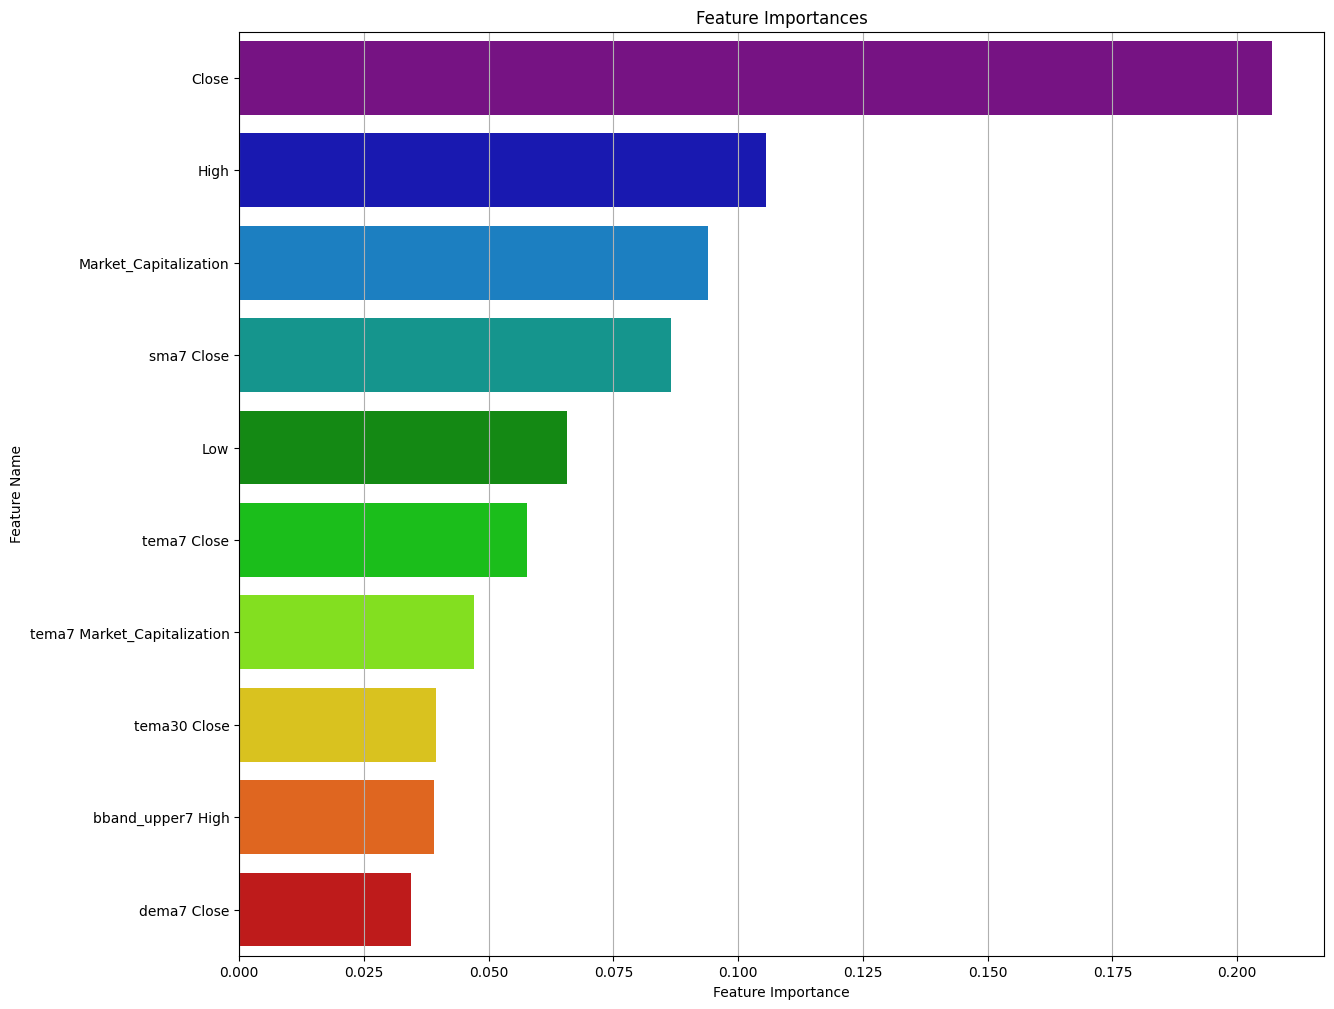

In [42]:
df_Important_feature,final_df_next_7th_day = feature_imp(X_scaled,rf_7th.feature_importances_,10)
final_df_next_7th_day.insert(loc=0, column='Date', value=final_df['Date'])
final_df_next_7th_day['next_7th_day_closing_price'] = final_df['next_7th_day_closing_price']
df_Important_feature.to_csv('df_Important_feature_10.csv',index=False)
final_df_next_7th_day.to_csv('final_df_next_7th_day_10.csv',index=False)

### 15 Important features for target 

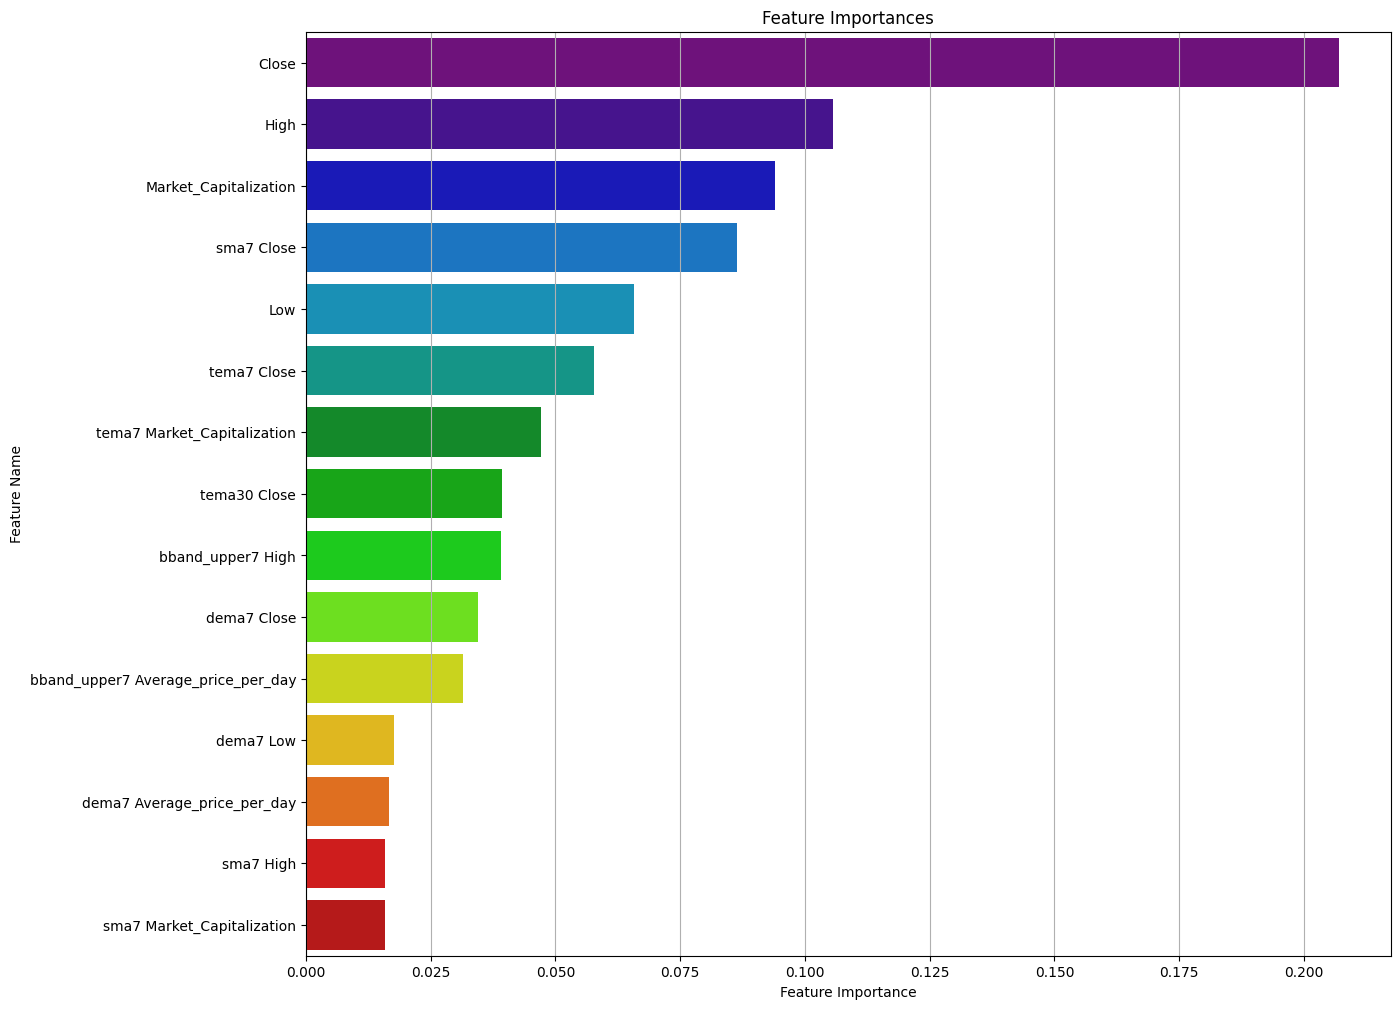

In [43]:
df_Important_feature,final_df_next_7th_day = feature_imp(X_scaled,rf_7th.feature_importances_,15)
final_df_next_7th_day.insert(loc=0, column='Date', value=final_df['Date'])
final_df_next_7th_day['next_7th_day_closing_price'] = final_df['next_7th_day_closing_price']
df_Important_feature.to_csv('df_Important_feature_15.csv',index=False)
final_df_next_7th_day.to_csv('final_df_next_7th_day_15.csv',index=False)


### 30 Important features for target 

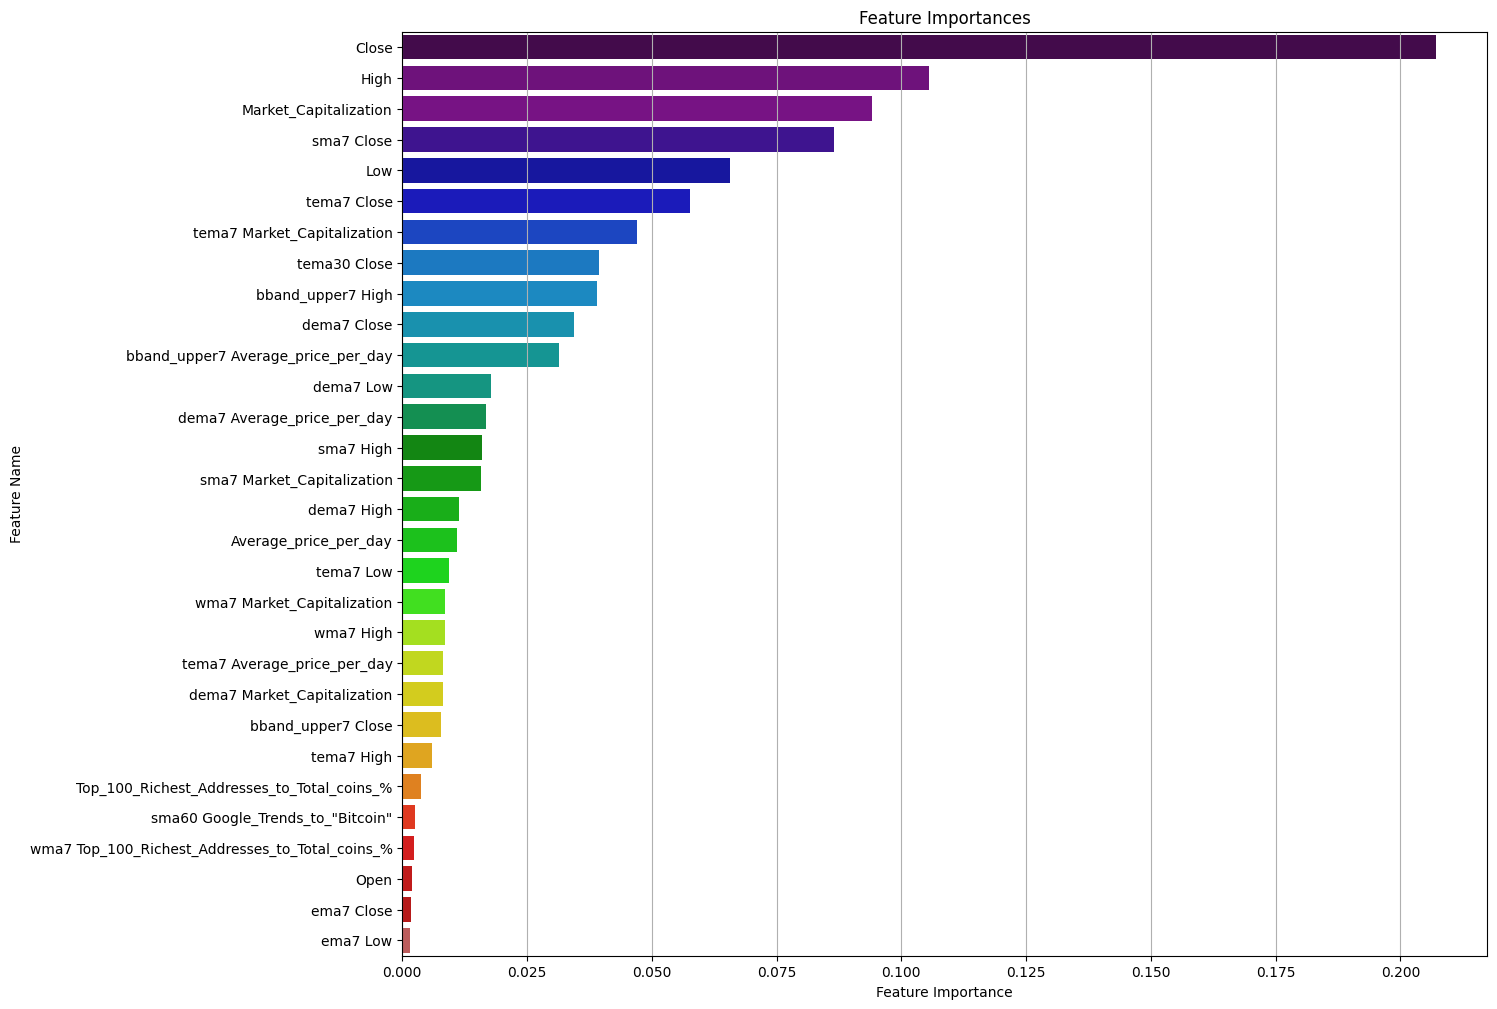

In [44]:
df_Important_feature,final_df_next_7th_day = feature_imp(X_scaled,rf_7th.feature_importances_,30)
final_df_next_7th_day.insert(loc=0, column='Date', value=final_df['Date'])
final_df_next_7th_day['next_7th_day_closing_price'] = final_df['next_7th_day_closing_price']
df_Important_feature.to_csv('df_Important_feature_30.csv',index=False)
final_df_next_7th_day.to_csv('final_df_next_7th_day_30.csv',index=False)